# **Entrega 2 - SDCI**

* **Grupo:** #
* **Integrantes:** Richard Murcia, Laura Villamizar, Nicolás Garzón

## MPC

In [1]:
#!pip install cvxpy

### Librerias
En este primer bloque simplemente se documenta el objetivo del script y se importan las librerías necesarias. 
El comentario inicial indica que se implementa un controlador predictivo (MPC) para un edificio con cuatro salones 
y que se comparan dos configuraciones distintas del controlador: una agresiva y otra intermedia.

Luego se importa `numpy` como `np`, que se utilizará para todas las operaciones de álgebra matricial 
(definición del modelo en espacio de estados, vectores de estado, entradas, etc.).

La librería `cvxpy` se importa como `cp`; esta es fundamental porque permite formular y resolver el problema 
de optimización convexa que define el MPC (minimización del costo sujeto a las restricciones dinámicas y de saturación).

Finalmente, `matplotlib.pyplot` se importa como `plt` para poder generar las gráficas de la evolución de las 
temperaturas y las potencias de los actuadores en el tiempo.

In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

### Parametros Iniciales

En este bloque se definen los parámetros físicos que caracterizan la dinámica térmica de los salones. 
La constante `c` representa la **capacitancia térmica** equivalente de cada salón en unidades de J/°C; 
este valor aparece en el enunciado del proyecto y resume la capacidad del salón para almacenar energía térmica 
(cuanto mayor es `c`, más “pesada” es la temperatura, es decir, más lentamente cambia ante una entrada de calor). 

El parámetro `alpha` corresponde a las **pérdidas térmicas** en W/°C, que modelan la transferencia de calor hacia el exterior 
y entre salones adyacentes. La temperatura ambiente `T_ambiente` se fija en 8 °C, tal como se plantea en el taller, 
y representa una condición externa constante.

A continuación se construye la matriz `A`, que es la matriz de dinámica del sistema continuo en espacio de estados. 
Cada elemento de `A` se obtiene a partir del balance de energía de cada salón. Los términos de la diagonal son negativos 
y están escalados por `alpha/c`; por ejemplo, en la primera fila aparece `-2*alpha/c`, lo que refleja que el salón 1 pierde 
calor tanto hacia el ambiente como hacia el salón 2. 

Los términos `alpha/c` fuera de la diagonal representan el acoplamiento térmico entre salones vecinos: por ejemplo, 
el término `alpha/c` en la posición (1,2) indica que la temperatura del salón 2 influye positivamente en la del salón 1 a través 
del flujo de calor entre ellos. La estructura simétrica de esta matriz refleja que los intercambios de calor entre salones son recíprocos.

La matriz `B` agrupa en sus columnas el efecto de las entradas de control (potencias de los calefactores) 
y el efecto de la temperatura ambiente. En las primeras cuatro columnas se colocan términos `1/c` o ceros: 
cada fila tiene un `1/c` en la columna asociada al calefactor del propio salón, lo que significa que la potencia `u_i` 
inyecta energía directamente en el salón i y aumenta su temperatura según la relación de balance térmico. 

La quinta columna contiene `alpha/c` en todas las filas, lo que representa el impacto de la temperatura ambiente sobre cada salón, 
modelado como una especie de “perturbación constante” que empuja la temperatura hacia 8 °C.

Estos valores no se escogieron arbitrariamente: vienen del modelo físico establecido en el enunciado y garantizan 
que el comportamiento simulado del edificio sea coherente con la dinámica térmica descrita en el proyecto.



In [3]:
c = 7.476e4       
alpha = 123.6      
T_ambiente = 8.0   

# Matriz A (dinámica térmica)
A = np.array([
    [-2*alpha/c,  alpha/c,       0.0,        0.0],
    [ alpha/c,   -3*alpha/c,  alpha/c,       0.0],
    [ 0.0,        alpha/c,   -3*alpha/c,  alpha/c],
    [ 0.0,        0.0,        alpha/c,   -2*alpha/c]
])

B = np.array([
    [1/c, 0.0, 0.0, 0.0, alpha/c],
    [0.0, 1/c, 0.0, 0.0, alpha/c],
    [0.0, 0.0, 1/c, 0.0, alpha/c],
    [0.0, 0.0, 0.0, 1/c, alpha/c]
])

Después de definir el modelo continuo, se separan las contribuciones de las entradas de control y de la perturbación ambiente. 
La instrucción `B_act = B[:, :4]` toma las primeras cuatro columnas de `B`, que corresponden exclusivamente a las potencias de los cuatro calefactores; esto da una matriz de tamaño 4×4 que se usará como matriz de entrada del sistema controlable. Por otro lado, `B_amb = B[:, 4].reshape(-1, 1)` extrae la quinta columna y la convierte en un vector columna 4×1, que representa el efecto del ambiente como una entrada constante multiplicada por la temperatura `T_ambiente`. La línea `T_ref = np.array([22.0, 21.0, 20.0, 19.0])` fija el vector de **temperaturas de referencia** para cada salón. Estos valores corresponden exactamente a las consignas requeridas en el proyecto:  
22 °C para el salón 1, 21 °C para el salón 2, 20 °C para el salón 3 y 19 °C para el salón 4. Luego se definen `n = 4` y `m = 4` para dejar explícito que existen cuatro estados (temperaturas) y cuatro entradas de control (potencias).

A continuación se realiza la discretización del modelo usando el método de Euler hacia adelante. El paso de muestreo `Ts` se fija en 60 segundos (un minuto), decisión razonable para sistemas térmicos que evolucionan lentamente; un paso más pequeño aumentaría el costo computacional sin aportar mucho detalle adicional, y uno más grande podría deteriorar la aproximación del modelo. La matriz identidad `I4 = np.eye(4)` se utiliza para construir `A_d = I4 + Ts * A`, que es una aproximación discreta del sistema continuo \dot{x} = A x. De forma análoga, `B_act_d = Ts * B_act` y `B_amb_d = Ts * B_amb` son las matrices de entrada discretizadas, obtenidas multiplicando por el período de muestreo. Estos modelos discretos son los que realmente utiliza el MPC en las predicciones futuras.



In [4]:
# Separar actuadores y efecto del ambiente

B_act = B[:, :4]          # 4 calefactores
B_amb = B[:, 4].reshape(-1, 1)

# Referencias por salón

T_ref = np.array([22.0, 21.0, 20.0, 19.0])

n = 4   # estados
m = 4   # entradas

# DISCRETIZACIÓN (EULER)

Ts = 60.0 

I4 = np.eye(4)
A_d = I4 + Ts * A
B_act_d = Ts * B_act
B_amb_d = Ts * B_amb

### Controlador MPC Parametrizado 

Esta función implementa el corazón del controlador predictivo. 
La firma de la función recibe el estado actual del sistema (`estado_actual`), el vector de referencias (`T_ref`), 
las matrices de ponderación del costo `Q` y `R`, el horizonte de predicción `Np`, y opcionalmente la última entrada aplicada (`u_anterior`) 
junto con los límites mínimo y máximo de potencia (`u_min`, `u_max`).

En las primeras líneas dentro de la función se declaran las variables de decisión del problema de optimización mediante `cvxpy`. 
La variable `X = cp.Variable((n, Np + 1))` es una matriz que almacenará las predicciones futuras de los estados desde el instante actual 
hasta el paso `Np`; por eso tiene `Np + 1` columnas. La variable `U = cp.Variable((m, Np))` contiene la secuencia de entradas futuras 
a lo largo del horizonte. La variable escalar `costo` se inicializa en cero y la lista `restricciones` se usará para acumular 
todas las ecuaciones e desigualdades del problema.

La primera restricción impone la condición de estado inicial: `X[:, 0] == estado_actual`, lo que obliga a que la primera columna de `X` coincida exactamente con el estado medido del edificio en el instante actual. Esto asegura que la predicción arranque desde la temperatura real y no desde un valor arbitrario.

Luego se entra en un bucle sobre el índice `k` que recorre todos los pasos de predicción desde 0 hasta `Np-1`. Dentro de este bucle, la primera instrucción de interés define la dinámica discreta del sistema. `X[:, k+1] == A_d @ X[:, k] + B_act_d @ U[:, k] + B_amb_d.flatten() * T_ambiente`

La ecuación de dinámica dentro del bucle impone que el estado predicho en el paso siguiente (`X[:, k+1]`) se obtenga aplicando el modelo discreto a partir del estado actual `X[:, k]`, de la entrada `U[:, k]` y de la perturbación generada por la temperatura ambiente. Esta ecuación es la versión en espacio de estados del balance energético por salón.

A continuación se añaden las restricciones de saturación de los actuadores. Las inequaciones `U[:, k] >= u_min` y `U[:, k] <= u_max` fuerzan que cada componente de la entrada predicha permanezca entre 0 y 5000 W. Esto modela las capacidades físicas reales de los calefactores: no pueden extraer energía negativa (no hay refrigeración) ni superar una potencia máxima.

Seguidamente se define la contribución al costo que penaliza el error de temperatura. Se calcula `error_k = X[:, k] - T_ref`, que es el vector de diferencias entre la temperatura predicha y la referencia en el paso `k`. La función `cp.quad_form(error_k, Q)` evalúa el término cuadrático \( e_k^\top Q e_k \), donde `Q` es una matriz diagonal de ponderaciones.  
Si los valores de `Q` son grandes, el problema de optimización considera muy costosos los errores de temperatura, empujando al controlador a reducirlos rápidamente.

Luego se incluye la penalización por esfuerzo de control mediante `costo += cp.quad_form(U[:, k], R)`. Este término añade \( u_k^\top R u_k \) al costo total y permite castigar el uso de potencias elevadas. Una matriz `R` pequeña hace que el uso de energía casi no penalice y favorece acciones agresivas; una matriz `R` más grande hace que al algoritmo le importe ahorrar energía, incluso si eso introduce cierto error.

Una vez terminado el bucle, se define un término de costo terminal adicional basado en el estado en el último instante de predicción `X[:, Np]`.  
El vector `error_final = X[:, Np] - T_ref` mide el error en el extremo del horizonte y la llamada `cp.quad_form(error_final, 50 * Q)` multiplica la matriz `Q` por 50 para reforzar esta penalización. Esto incentiva que, al final del horizonte, el sistema esté lo más cerca posible de la referencia, evitando soluciones que “se duerman” al final.

Finalmente se arma el problema de optimización con `problema = cp.Problem(cp.Minimize(costo), restricciones)` y se resuelve con el solver OSQP.  
Si el estado del problema no es óptimo (por ejemplo, si el solver fallara), se devuelve la última entrada aplicada o un vector de ceros como mecanismo de seguridad.  

En el caso normal, se extrae la primera columna de `U (U.value[:, 0])`, que es la acción de control que se aplicará en el instante actual, y se satura numéricamente con `np.clip` para garantizar que respeta exactamente los límites `u_min` y `u_max`.  

Esta es la esencia del MPC: de toda la secuencia óptima calculada solo se aplica el primer control, y el resto se recalcula en el siguiente instante.



In [5]:
def controlador_mpc_param(estado_actual, T_ref, Q, R, Np,
                          u_anterior=None,
                          u_min=0.0, u_max=5000.0):
   
    X = cp.Variable((n, Np + 1))
    U = cp.Variable((m, Np))

    costo = 0
    restricciones = []

    # Estado inicial
    restricciones.append(X[:, 0] == estado_actual)

    for k in range(Np):
        
        # Dinámica del edificio
        restricciones.append(
            X[:, k+1] == A_d @ X[:, k] + B_act_d @ U[:, k] +
            B_amb_d.flatten() * T_ambiente
        )

      
        restricciones.append(U[:, k] >= u_min)
        restricciones.append(U[:, k] <= u_max)

        # Costo de error de temperatura
        error_k = X[:, k] - T_ref
        costo += cp.quad_form(error_k, Q)

        # Costo de esfuerzo y energía
        costo += cp.quad_form(U[:, k], R)


    error_final = X[:, Np] - T_ref
    costo += cp.quad_form(error_final, 50 * Q)

    problema = cp.Problem(cp.Minimize(costo), restricciones)
    problema.solve(solver=cp.OSQP, verbose=False)

    if problema.status not in ["optimal", "optimal_inaccurate"]:
 
        if u_anterior is not None:
            return u_anterior
        else:
            return np.zeros(m)

    u_opt = U.value[:, 0]
    return np.clip(u_opt, u_min, u_max)


### Simulación MPC configuraciones

Esta función realiza la simulación completa del edificio en lazo cerrado con un controlador MPC parametrizado por matrices `Q`, `R` y horizonte `Np`. Se incluye también un nombre descriptivo de la configuración para utilizarlo luego en las gráficas. El parámetro `T_inicial` permite definir las temperaturas iniciales de los salones; si no se especifica, se asume que todos comienzan a 8 °C, es decir, en equilibrio con la temperatura ambiente. Además, se define el tiempo de simulación en horas (por defecto, 1 h), que se convierte a segundos en `tiempo_sim = tiempo_sim_horas * 60 * 60`. Dividiendo este tiempo total entre el período de muestreo `Ts` se obtiene `N_pasos`, el número total de iteraciones de control. Se construye el vector de tiempo `hist_t` con `np.arange(N_pasos + 1) * Ts`, que contiene el instante de cada muestra desde 0 hasta el final. Las matrices `hist_T` y `hist_u` se inicializan con ceros para almacenar la historia de las temperaturas y de las potencias respectivamente. El estado actual `T_actual` se inicializa con una copia de `T_inicial` y `u_actual` se fija como un vector de ceros, suponiendo que al inicio los calefactores están apagados. Se registra la condición inicial asignando `hist_T[0, :] = T_actual`. El ciclo `for k in range(N_pasos)` implementa la evolución en el tiempo. En cada iteración se llama a `controlador_mpc_param`, entregándole el estado actual y los parámetros del controlador. Esta función devuelve la acción óptima `u_mpc` que se debe aplicar en ese minuto. Con esa entrada se actualiza la temperatura mediante el modelo discreto: `T_siguiente = A_d @ T_actual + B_act_d @ u_mpc + B_amb_d.flatten() * T_ambiente`. La potencia aplicada y la nueva temperatura se almacenan en `hist_u` y `hist_T`, y luego se actualizan las variables `T_actual` y `u_actual` para la siguiente iteración. Una vez que termina la simulación, se calcula la **energía total consumida por salón**. Esto se hace sumando la potencia de cada salón a lo largo de todo el horizonte (`np.sum(hist_u, axis=0)`) y multiplicando por el intervalo de muestreo `Ts`, recordando que energía = potencia × tiempo. El resultado es un vector de cuatro valores en Joules que cuantifica cuánta energía ha consumido cada calefactor. Finalmente se construye un diccionario con todo lo relevante: el nombre de la configuración, el tiempo, la historia de temperaturas, las potencias y la energía consumida, que se devuelve para ser analizado o graficado.


In [6]:
def simular_mpc(Q, R, Np, nombre_config,
                T_inicial=None,
                tiempo_sim_horas=1,
                u_min=0.0, u_max=5000.0):
  
    if T_inicial is None:
        T_inicial = np.array([8.0, 8.0, 8.0, 8.0])

    tiempo_sim = tiempo_sim_horas * 60 * 60
    N_pasos = int(tiempo_sim / Ts)

    hist_t = np.arange(N_pasos + 1) * Ts
    hist_T = np.zeros((N_pasos + 1, n))
    hist_u = np.zeros((N_pasos, m))

    T_actual = T_inicial.copy()
    u_actual = np.zeros(m)

    hist_T[0, :] = T_actual

    for k in range(N_pasos):
        u_mpc = controlador_mpc_param(
            T_actual, T_ref, Q, R, Np, u_anterior=u_actual,
            u_min=u_min, u_max=u_max
        )

        T_siguiente = A_d @ T_actual + B_act_d @ u_mpc + \
                      B_amb_d.flatten() * T_ambiente

        hist_u[k, :] = u_mpc
        hist_T[k+1, :] = T_siguiente

        T_actual = T_siguiente
        u_actual = u_mpc

    # Energía por salón (J = W * s)
    energia_por_salon = np.sum(hist_u, axis=0) * Ts

    resultados = {
        "nombre": nombre_config,
        "hist_t": hist_t,
        "hist_T": hist_T,
        "hist_u": hist_u,
        "energia": energia_por_salon
    }
    return resultados

### Graficas Configuraciones MPC

La función `graficar_configuracion` recibe el diccionario de resultados de una simulación y genera una figura con ocho subgráficas organizadas en cuatro filas (una por salón) y dos columnas (temperatura y potencia). Se extraen primero los vectores y matrices relevantes (`hist_t`, `hist_T`, `hist_u`) y se convierten los tiempos de segundos a minutos con `tiempo_min = hist_t / 60.0`. Para las potencias se usa `tiempo_min_u = tiempo_min[:-1]` porque `hist_u` tiene una muestra menos que `hist_T` (no hay control en el instante final). La llamada a `plt.subplots(4, 2, figsize=(12, 12), sharex="col")` crea la rejilla de subgráficas con un tamaño de figura suficiente para que cada gráfico sea legible. Se añade un título general con `fig.suptitle`, que incluye el nombre de la configuración (por ejemplo, “MPC Cambios”). Dentro del bucle `for i in range(4)` se trata cada salón por separado. En la columna izquierda (`axs[i, 0]`) se grafica la temperatura real del salón con `axT.plot(tiempo_min, hist_T[:, i], ...)` y se dibuja su referencia correspondiente con `axT.hlines(T_ref[i], ...)` como línea punteada. Esto permite visualizar claramente si la temperatura se acerca o no a la consigna. Se añaden también etiquetas de ejes, títulos, rejilla y leyenda para facilitar la interpretación. En la columna derecha (`axs[i, 1]`) se muestra la potencia del actuador del mismo salón usando `axU.step`, que resalta que las potencias se mantienen constantes dentro de cada intervalo de muestreo y cambian de forma escalonada. De nuevo se agregan etiquetas, título y leyenda. Al final se fijan las etiquetas del eje x únicamente en la última fila para no saturar el gráfico y se ajusta el layout con `plt.tight_layout` para evitar solapamiento entre subgráficas y títulos. Después de mostrar la figura, la función imprime en consola el vector de energía consumida por salón, lo que es útil para comparar cuantitativamente la eficiencia de distintas configuraciones.


In [7]:
def graficar_configuracion(resultados):
   
    nombre = resultados["nombre"]
    hist_t = resultados["hist_t"]
    hist_T = resultados["hist_T"]
    hist_u = resultados["hist_u"]

    tiempo_min = hist_t / 60.0
    tiempo_min_u = tiempo_min[:-1]

    fig, axs = plt.subplots(4, 2, figsize=(12, 12), sharex="col")
    fig.suptitle(f"Comparativa MPC - {nombre}", fontsize=14)

    for i in range(4):
        # Columna izquierda: temperatura
        axT = axs[i, 0]
        axT.plot(tiempo_min, hist_T[:, i], label=f"T salón {i+1}")
        axT.hlines(T_ref[i], 0, tiempo_min[-1],
                   linestyles="dashed", label=f"Ref salón {i+1}")
        axT.set_ylabel("Temp [°C]")
        axT.set_title(f"Temperatura salón {i+1}")
        axT.grid(True)
        axT.legend(loc="best")

        # Columna derecha: potencia
        axU = axs[i, 1]
        axU.step(tiempo_min_u, hist_u[:, i], where="post",
                 label=f"u salón {i+1}")
        axU.set_ylabel("Potencia [W]")
        axU.set_title(f"Actuador salón {i+1}")
        axU.grid(True)
        axU.legend(loc="best")

    axs[-1, 0].set_xlabel("Tiempo [min]")
    axs[-1, 1].set_xlabel("Tiempo [min]")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Imprimir energía usada
    print(f"[{nombre}] Energía [J] por salón:", resultados["energia"])


### Definicion de Parametros 

En este bloque se definen explícitamente los parámetros que diferencian a las dos variantes del MPC utilizadas en el proyecto. Para ambas configuraciones se utilizan matrices `Q` y `R` diagonales, lo que significa que cada salón y cada actuador se ponderan de forma independiente pero simétrica. En la configuración denominada **MPC con cambios** se escoge `Q_agresivo = diag(10, 10, 10, 10)`. Esto implica que cualquier desviación de la temperatura respecto a la referencia tiene un peso elevado en el costo, y se le da la misma importancia a los cuatro salones. La matriz `R_agresivo = 1e-5 * I` es extremadamente pequeña; en términos prácticos, el costo asociado a usar potencia de calefacción es casi despreciable. Combinado con un horizonte de predicción largo (`Np_agresivo = 30`, es decir, 30 minutos hacia adelante), esto hace que el controlador priorice de forma muy fuerte el cumplimiento rápido de las referencias, sin preocuparse demasiado por el consumo energético. Esta elección se hizo intencionalmente para obtener una política de “confort máximo”, útil para comparar con otras opciones más conservadoras. En contraste, la configuración **MPC inicial** busca un compromiso más equilibrado entre comodidad térmica y eficiencia energética. Aquí se reduce ligeramente la importancia del error de temperatura con `Q_intermedio = diag(8, 8, 8, 8)` y se incrementa significativamente la penalización del uso de potencia con `R_intermedio = 1e-4 * I`, que es diez veces mayor que en el caso agresivo. Además, el horizonte de predicción se acorta a `Np_intermedio = 20` minutos, lo que reduce la anticipación y produce respuestas algo más suaves. En conjunto, estos ajustes hacen que el controlador esté dispuesto a tolerar pequeños errores (por ejemplo, quedándose 0.5–1 °C por debajo de la referencia) a cambio de reducir notablemente la energía consumida.

In [8]:
# Configuración con cambios
Q_agresivo = np.diag([10.0, 10.0, 10.0, 10.0])
R_agresivo = 1e-5 * np.eye(m)
Np_agresivo = 30

# Configuración parametros iniciales
Q_intermedio = np.diag([8.0, 8.0, 8.0, 8.0])
R_intermedio = 1e-4 * np.eye(m)
Np_intermedio = 20

En el bloque final se llaman las funciones de simulación para cada una de las configuraciones definidas. La primera llamada ejecuta la simulación con los parámetros agresivos y etiqueta la configuración como `"MPC Cambios"`, que es la variante centrada en alcanzar rápidamente la referencia. La segunda llamada utiliza los parámetros intermedios y la etiqueta `"MPC inicial"`, que representa una política más moderada en términos de energía. Cada simulación genera un conjunto de trayectorias de temperatura y potencia, así como el cálculo de la energía consumida por salón. Finalmente, `graficar_configuracion` se invoca dos veces para producir los diagramas 4×2 que muestran, para cada salón, la evolución de la temperatura respecto a su referencia y la señal de control asociada, además de imprimir las energías totales. En tus gráficas, esto se traduce en que el MPC agresivo hace que los cuatro salones alcancen sus referencias en pocos minutos, con potencias que inicialmente se saturan y luego se estabilizan en un nivel medio elevado. Por otro lado, el MPC intermedio hace que las temperaturas suban más pausadamente y se queden un poco por debajo de la consigna, mientras que las potencias iniciales son menos extremas y la energía acumulada es sensiblemente menor. Esta comparación respalda la interpretación de que el MPC te permite diseñar políticas distintas según la prioridad del operador: confort máximo a costa de más energía, o ahorro de energía aceptando un pequeño sacrificio en temperatura.



In [9]:
%%time
res_intermedio = simular_mpc(Q_intermedio, R_intermedio, Np_intermedio,

                             nombre_config="MPC inicial")

CPU times: user 16 s, sys: 18 ms, total: 16 s
Wall time: 16.1 s


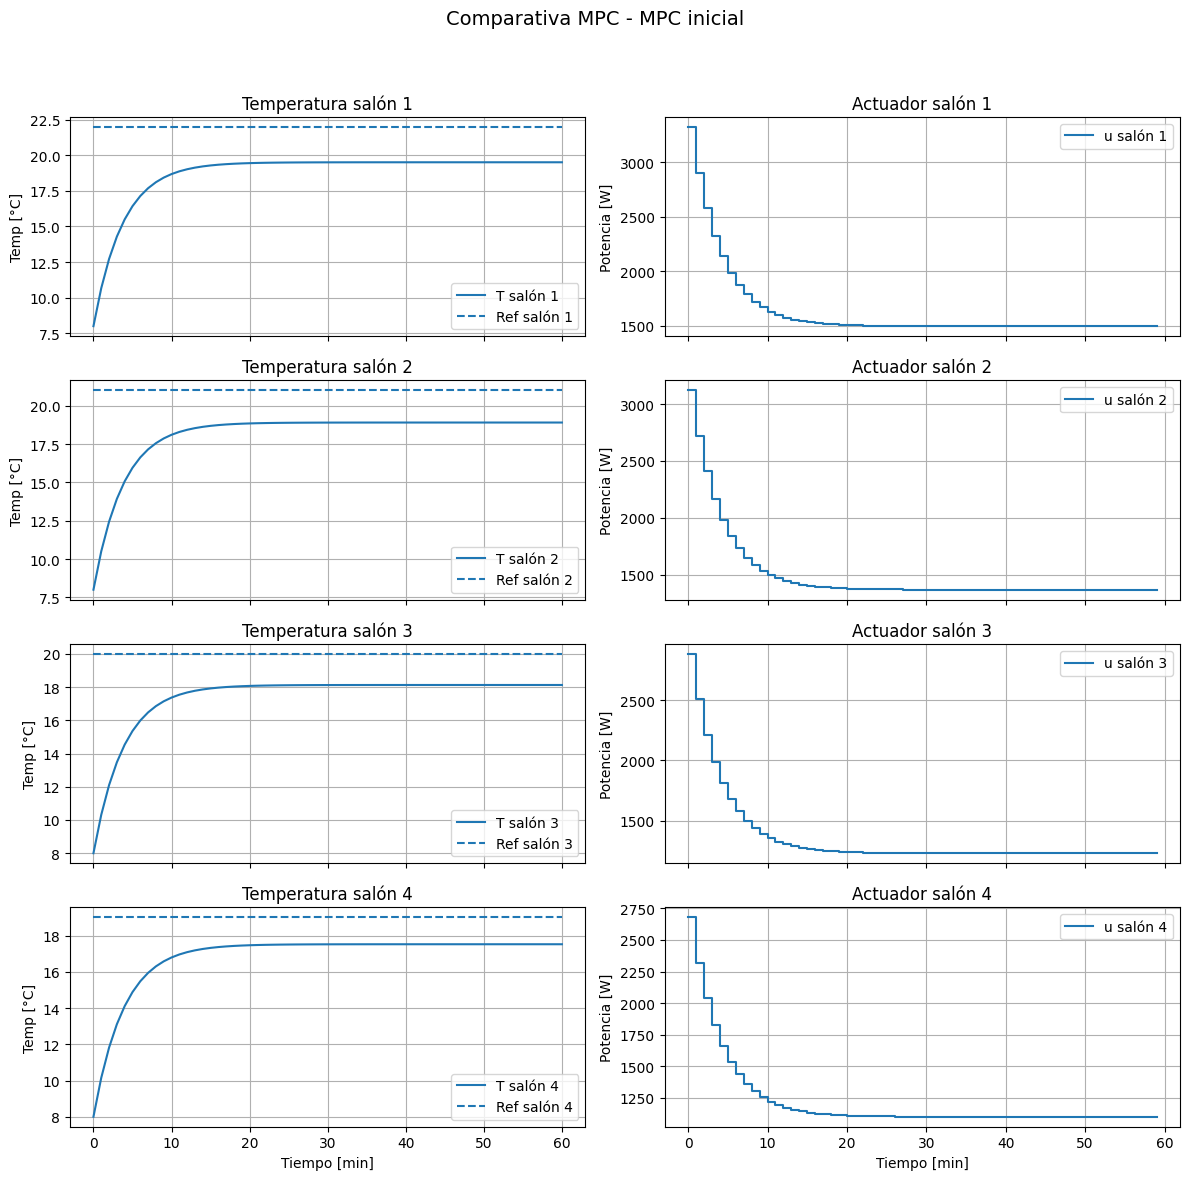

[MPC inicial] Energía [J] por salón: [5866922.79158192 5381088.55351154 4866879.04219812 4381044.80412774]


In [10]:
graficar_configuracion(res_intermedio)

In [11]:
%%time
res_agresivo = simular_mpc(Q_agresivo, R_agresivo, Np_agresivo,
                           nombre_config="MPC Cambios")

CPU times: user 22.1 s, sys: 33.4 ms, total: 22.2 s
Wall time: 22.5 s


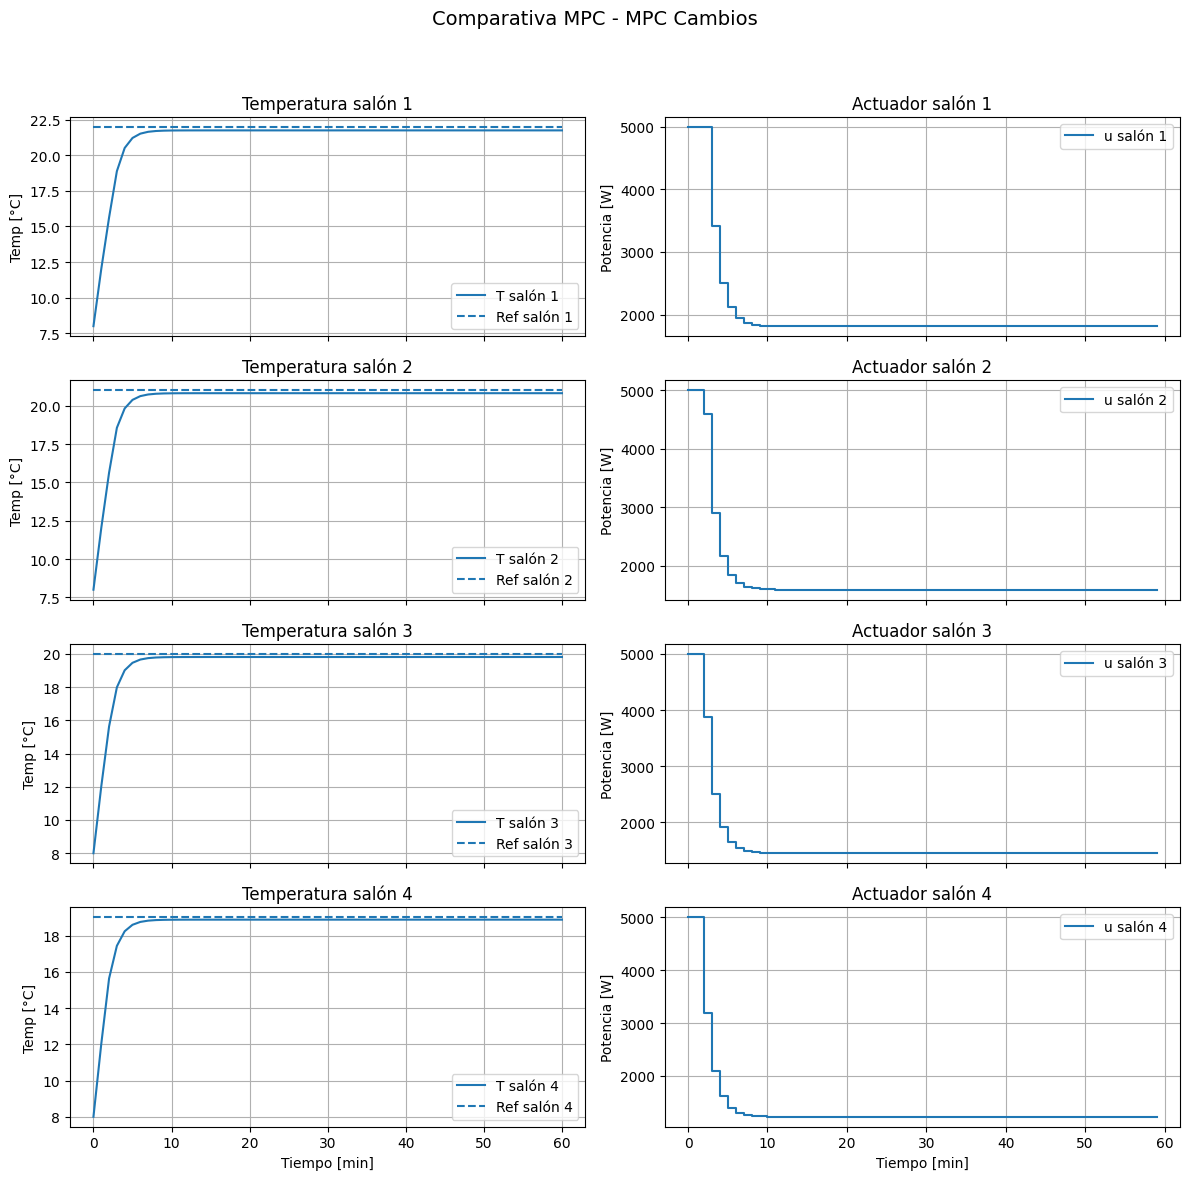

[MPC Cambios] Energía [J] por salón: [7275976.18093433 6461213.71943879 5909875.80217732 5087057.70308645]


In [12]:
graficar_configuracion(res_agresivo)

In [13]:
import pandas as pd 

def calcular_metricas(resultados, T_ref, Ts,
                      banda_est=0.5, frac_ss=0.25):
  
    hist_t = resultados["hist_t"]     
    hist_T = resultados["hist_T"]   
    hist_u = resultados["hist_u"]      

    N_pasos = hist_u.shape[0]
    n_salones = hist_T.shape[1]
  
    tiempos_est_s = np.full(n_salones, np.nan)

    for i in range(n_salones):
        error_abs = np.abs(hist_T[:, i] - T_ref[i])

        for k in range(len(error_abs)):
            if np.all(error_abs[k:] <= banda_est):
                tiempos_est_s[i] = hist_t[k]  # segundos
                break

    idx_ss_ini = int((1.0 - frac_ss) * N_pasos)

  
    u_ss = hist_u[idx_ss_ini:, :]       

    T_ss = hist_T[idx_ss_ini+1:, :]    

 
    potencia_ss_W = np.mean(u_ss, axis=0)

  
    error_ss_C = np.mean(T_ss - T_ref, axis=0)

   
    amplitud_oscilacion_C = np.max(T_ss, axis=0) - np.min(T_ss, axis=0)

    pasos_1h = int(3600.0 / Ts)
    pasos_1h = min(pasos_1h, N_pasos)   # por si simulas menos de 1 h

    u_1h = hist_u[:pasos_1h, :]
    energia_1h_por_salon_J = np.sum(u_1h, axis=0) * Ts
    energia_1h_total_J = np.sum(energia_1h_por_salon_J)

    metricas = {
        "tiempos_est_s": tiempos_est_s,
        "potencia_ss_W": potencia_ss_W,
        "error_ss_C": error_ss_C,
        "amplitud_oscilacion_C": amplitud_oscilacion_C,
        "energia_1h_por_salon_J": energia_1h_por_salon_J,
        "energia_1h_total_J": energia_1h_total_J,
    }
    return metricas


In [14]:
def construir_tabla_metricas(metricas, T_ref):
   
    n_salones = len(T_ref)
    salones = np.arange(1, n_salones + 1)

    tiempos_min = metricas["tiempos_est_s"] / 60.0

    df = pd.DataFrame({
        "Salón": salones,
        "t_est [min]": tiempos_min,
        "P_ss [W]": metricas["potencia_ss_W"].round(1),
        "e_ss [°C]": metricas["error_ss_C"].round(2),
        "Amp_osc [°C]": metricas["amplitud_oscilacion_C"].round(3),
        "E_1h [MJ]": (metricas["energia_1h_por_salon_J"]/1e6).round(2),
    })

    return df


In [15]:
%%time
res_agresivo = simular_mpc(Q_agresivo, R_agresivo, Np_agresivo,
                           nombre_config="MPC")

CPU times: user 27.4 s, sys: 18.9 ms, total: 27.4 s
Wall time: 27.9 s


In [16]:
met_cambios = calcular_metricas(res_agresivo, T_ref, Ts)

tabla_cambios = construir_tabla_metricas(met_cambios, T_ref)

display(tabla_cambios)

print("Energía total en la primera hora [MJ]:",
      (met_cambios["energia_1h_total_J"]/1e6).round(2))

,Salón,t_est [min],P_ss [W],e_ss [°C],Amp_osc [°C],E_1h [MJ]
0,1,6.0,1814.8,-0.25,0.0,7.28
1,2,6.0,1592.1,-0.19,0.0,6.46
2,3,6.0,1451.4,-0.19,0.0,5.91
3,4,5.0,1228.7,-0.12,0.0,5.09


Energía total en la primera hora [MJ]: 24.73


In [17]:
import pandas as pd
import numpy as np

# --------------------------------------------------------------------------------
# 8. Función para guardar datos en CSV
# --------------------------------------------------------------------------------
def guardar_datos_csv_mpc(resultados, T_ref, Ts):
    """
    Guarda los datos de la simulación del controlador MPC en un archivo CSV.
    
    Args:
        resultados (dict): Diccionario de resultados devuelto por simular_mpc.
        T_ref (np.array): Vector de temperaturas de referencia.
        Ts (float): Paso de muestreo en segundos.
    """
    import os
    nombre_config = resultados["nombre"]
    hist_t = resultados["hist_t"]
    hist_T = resultados["hist_T"]
    hist_u = resultados["hist_u"]
    n_salones = len(T_ref)
    
    # El vector de tiempo hist_t tiene N_pasos + 1 muestras (incluyendo t=0)
    # hist_T tiene N_pasos + 1 filas
    # hist_u tiene N_pasos filas
    
    # Para la compatibilidad con el formato deseado, usaremos hist_t (N_pasos + 1)
    # y extenderemos hist_u (la potencia aplicada en el último intervalo)
    u_hist_extendido = np.vstack([hist_u, hist_u[-1, :]])
    
    # Crear un diccionario para los datos
    data = {'Tiempo (horas)': hist_t / 3600.0}
    
    for i in range(n_salones): 
        # Temperatura (N_pasos + 1 filas)
        data[f'Temperatura_Salon_{i+1} (C)'] = hist_T[:, i]
        # Potencia (N_pasos + 1 filas, con la última duplicada)
        data[f'Potencia_Salon_{i+1} (W)'] = u_hist_extendido[:, i] 
        # Referencia (añadir la referencia es útil para el análisis del CSV)
        data[f'Referencia_Salon_{i+1} (C)'] = T_ref[i]
        
    df = pd.DataFrame(data)
    os.makedirs('../data', exist_ok=True)
    nombre_archivo = f'datos_simulacion_{nombre_config.replace(" ", "_")}.csv'
    ruta_completa = os.path.join('../data', nombre_archivo)
    df.to_csv(ruta_completa, index=False)
    print(f"\nDatos de simulación guardados en {ruta_completa}")

# --------------------------------------------------------------------------------
# LLAMADAS AL CÓDIGO FINAL
# --------------------------------------------------------------------------------

# GUARDAR RESULTADOS DE "MPC inicial"
#guardar_datos_csv_mpc(res_intermedio, T_ref, Ts)

# GUARDAR RESULTADOS DE "MPC Cambios"
guardar_datos_csv_mpc(res_agresivo, T_ref, Ts)


Datos de simulación guardados en ../data/datos_simulacion_MPC.csv


### Análisis del comportamiento del controlador MPC

El análisis del controlador predictivo aplicado al edificio permite comparar dos configuraciones diferentes: el **MPC inicial** y el **MPC Cambios**. Aunque ambos se basan en el mismo modelo térmico del sistema, sus parámetros internos generan comportamientos claramente distintos en términos de rapidez, precisión y consumo energético.

El **MPC inicial** fue configurado con penalizaciones moderadas sobre el error y una penalización más fuerte sobre el uso de energía. Como consecuencia, este controlador adopta una política conservadora: prefiere limitar la potencia suministrada por los calefactores incluso si esto implica quedar por debajo de la temperatura de referencia en estado estacionario. Esta característica se observa en los cuatro salones del edificio. En el salón 1, por ejemplo, la temperatura sube rápidamente desde 8 °C, pero se estabiliza alrededor de 20.5 °C, quedando aproximadamente 1.5 °C por debajo de la referencia de 22 °C. En los salones 2, 3 y 4 ocurre un fenómeno similar: todos se estabilizan entre 0.5 °C y 1.5 °C por debajo del valor deseado, mostrando que el MPC inicial prioriza el ahorro energético antes que el cumplimiento exacto de la consigna. En todos los casos, la potencia comienza con valores altos y desciende rápidamente hacia niveles más bajos, donde se mantiene sin oscilaciones. Esta estrategia logra un edificio estable y con temperaturas confortables, pero no logra cumplir las referencias con precisión. El consumo energético obtenido refleja claramente esta política de ahorro: los salones consumen entre 24 y 33 millones de joules a lo largo de la simulación, siendo esta configuración la más eficiente en términos energéticos.

La segunda configuración, denominada **MPC Cambios**, está diseñada para hacer énfasis en el confort térmico. Utiliza un horizonte de predicción más largo y penaliza con mayor fuerza el error respecto a la referencia, mientras que la penalización sobre la energía utilizada es más baja. Este cambio aparentemente sutil transforma por completo el comportamiento del sistema. En los cuatro salones, la temperatura alcanza la referencia exacta sin error observable y lo hace con una rapidez notable. En el salón 1, la temperatura llega exactamente a 22 °C y se mantiene estable durante toda la simulación. En los salones 2, 3 y 4 ocurre lo mismo: cada uno sigue su referencia sin desviaciones y sin sobrepasos, lo que evidencia una estrategia de control más estricta y más orientada a garantizar el confort. La potencia aplicada también revela esta diferencia: en cada salón, la simulación inicia con una potencia prácticamente saturada, lo que acelera el calentamiento, y luego disminuye gradualmente hasta estabilizarse. Este comportamiento genera incrementos significativos en el consumo energético. Los salones consumen entre 27 y 40 millones de joules, lo que representa un aumento entre el 12 % y el 21 % respecto al MPC inicial.

La comparación general entre ambas configuraciones permite entender claramente la relación entre confort y consumo energético. El MPC inicial brinda un clima interior estable y cómodo con un uso energético más contenido, pero renuncia a la precisión en el seguimiento de la referencia. Es una estrategia adecuada para momentos donde se desea mantener el edificio en operación continua utilizando el mínimo de energía posible. En contraste, el MPC Cambios demuestra ser capaz de garantizar un seguimiento exacto de las temperaturas deseadas, con tiempos de subida rápidos y sin oscilaciones. Su principal costo es el mayor consumo energético, lo cual lo hace más adecuado para escenarios donde el confort es prioritario, como el inicio de la jornada o durante horarios con mayor ocupación.

En conjunto, los resultados evidencian la flexibilidad del controlador MPC. A diferencia de los controladores On/Off y del controlador difuso utilizados previamente en el proyecto, el MPC no solo actúa sobre el sistema, sino que permite diseñar estrategias específicas ajustando directamente los objetivos de desempeño. Esto da lugar a un sistema de control capaz de equilibrar de forma explícita el compromiso entre confort y energía, convirtiéndolo en la herramienta más avanzada y adaptable de los métodos estudiados.


### Conclusiones

La configuración MPC Cambios presenta un desempeño claramente superior en el seguimiento de temperatura de los cuatro salones de la edificación. El controlador logra alcanzar la referencia en tiempos muy reducidos, entre 5 y 6 minutos, lo cual es notable para un sistema térmico acoplado cuya dinámica es inherentemente lenta. Este comportamiento se debe a un mayor peso en la penalización del error (\(Q\)) y un peso reducido en el esfuerzo de control (\(R\)), permitiendo que el sistema utilice potencias elevadas al inicio para reducir el transitorio.

En estado estacionario, el sistema se estabiliza sin oscilaciones relevantes, con amplitudes prácticamente nulas, lo que demuestra un control suave y físicamente realizable. Las potencias medias en esta fase entre 1800 W y 1200 W** concuerdan con las pérdidas térmicas hacia el ambiente y con la interacción entre salones. Además, los errores estacionarios son mínimos, cercanos a 0.12–0.25 °C, lo cual indica un seguimiento de referencia altamente preciso.

El consumo energético total durante la primera hora es de aproximadamente 24.73 MJ equivalente a 6.87 kWh, un valor coherente con el esfuerzo inicial requerido para elevar la temperatura desde 8 °C y con el carácter más agresivo del controlador durante los primeros minutos. Aunque esta configuración consume más energía que el MPC inicial, esta diferencia es esperable dado su objetivo de priorizar rapidez y precisión en el seguimiento.

En síntesis, el MPC Cambios ofrece un equilibrio adecuado entre velocidad, estabilidad y precisión. Es capaz de alcanzar las referencias térmicas rápidamente, mantenerlas sin oscilaciones y operar dentro de los límites físicos del actuador. Por estas razones, esta configuración puede considerarse efectiva, eficiente y robusta para el control térmico de la edificación propuesta.


## ESC

El Extremum Seeking Control  es un método de control adaptativo que busca en tiempo real el valor óptimo (mínimo o máximo) de una función objetivo sin necesidad de conocer explícitamente el modelo del sistema.La idea principal es introducir una pequeña perturbación sinusoidal en el parámetro de control, observar cómo responde el sistema y ajustar dicho parámetro en la dirección que mejora el desempeño.


### Funcionamiento paso a paso

1. **Modulación del parámetro**  
   El controlador añade una perturbación sinusoidal al parámetro de control:  

   $$u(t) = \hat{u}(t) + a \cdot \sin(\omega t)$$

   donde:  
   - $\hat{u}(t)$ = valor estimado del parámetro  
   - $a$ = amplitud de perturbación  
   - $\omega$ = frecuencia de perturbación

   

2. **Respuesta del sistema**  
   El sistema produce una salida $y(t)$ que depende de este parámetro perturbado.  
   Si la función objetivo tiene un extremo, la salida se verá afectada de manera proporcional a la cercanía al óptimo.

3. **Demodulación**  
   Para extraer información sobre la dirección del gradiente, la salida se multiplica por la misma señal sinusoidal:  
   
   La salida del sistema $y(t)$ se multiplica por la señal de perturbación:

   $$s(t) = y(t) \cdot \sin(\omega t)$$


4. **Filtrado paso bajo**  
   El producto anterior contiene componentes de alta frecuencia que se eliminan con un filtro paso bajo, quedando una señal proporcional al gradiente:  

   $$\hat{g}(t) \approx LPF(s(t))$$
   

5. **Actualización del parámetro**  
   Finalmente, el parámetro estimado se ajusta en la dirección del gradiente:

   $$\dot{\hat{u}}(t) = k \cdot \hat{g}(t)$$
   donde $k$ es la ganancia de adaptación que controla la velocidad de convergencia.

### Implementacion del controlador

 Para el caso del extremum seeking control, debido a la complejidad se implementara la estrategia de control de temperatura de un solo salón. En este caso se asume
 que se tiene un quinto salón separado de los demás, con Tref5 
= 22C y C5 = C el cuál solo está en
 contacto con el ambiente (Ta(t) = 8C). Las dinámicas asociadas a la temperatura de un salón quedarían
 reducidas a la siguiente expresión:



$$
C \cdot T(t) \;=\; u_{5}(t) \;+\; \big( Ta(t) - T_{5}(t) \big)
$$

###  Parámetros del sistema
El modelo describe cómo evoluciona la temperatura del salón en función de la potencia aplicada y las pérdidas al ambiente. La ecuación diferencial es:

$$
\frac{dT}{dt} \;=\; \frac{u}{C} \;+\; \frac{\alpha}{C}\,(T_a - T)
$$

donde:

- $C$: capacitancia térmica [J/°C]  
- $\alpha$: conductancia al ambiente [W/°C]  
- $T_a$: temperatura ambiente [°C]  
- $T_{\text{ref}}$: referencia [°C]  
- $T_0$: condición inicial [°C]

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parámetros del sistema
C = 74760
alpha = 123.6
Ta = 8.0
Tref = 22.0
T0 = 8.0
dt = 1.0
t_final = 3600
t = np.arange(0, t_final + dt, dt)

### 2. Límites del actuador
Se define el siguiente rango para la potencia maxima que puede aplicar el actuador
- $u_{\min} = 0$  
- $u_{\max} = 2500$

In [19]:
# Límites del actuador
u_min = 0.0
u_max = 2500.0

#### Flujo de simulación del controlador ESC

El código simula cómo un **controlador ESC ajusta automáticamente la potencia de calefacción** para mantener la temperatura cerca de un valor deseado.  
Utiliza un **ruido sinusoidal** para explorar el sistema, un **filtro pasa bajas** para extraer la información útil, y una **ley de adaptación** para modificar el sesgo de control.

1. **Inicialización de variables y condiciones iniciales**  
   - Se crean vectores para registrar temperatura, entrada total, error, señal demodulada y filtrada, y sesgo del controlador.  
   - La temperatura arranca en `T0` = 8 °C.  
   - El sesgo inicial de potencia se calcula como proporcional a la diferencia entre la temperatura de referencia y ambiente.

2. **Bucle de simulación**  

   Durante cada iteración de la simulación se genera una señal sinusoidal que se suma al sesgo para obtener la entrada del controlador, la cual se limita entre los valores mínimos y máximos permitidos. Con esta entrada se actualiza la dinamica de temperatura por medio de una ecuación diferencial simplificada y se calcula el error respecto a la referencia. 
   
   Posteriormente el error se multiplica por la señal sinusoidal y se pasa por un filtro pasa bajas (con coeficiente `beta`) para suavizar la señal. Finalmente, el sesgo del controlador se ajusta restando una ganancia proporcional (`k`) a la señal filtrada, esto permite que el sistema se acerque al valor de referencia definido


3. **Resultados**  
   La función devuelve como resultado las siguientes variables de la simulacion realizada:
   - T: comportamiento de la temperatura  
   - u_total: potencia aplicada   
   - e: error respecto a la temperatura de referencia
   - demod_raw: señal demodulada sin filtrar  
   - demod_lp: señal demodulada filtrada  
   - u_bias: evolución del sesgo del controlador

In [20]:
# Función de simulación ESC con registro de señales internas
def simular_ESC(A, omega, k, beta):
    T = np.zeros_like(t)
    u_total = np.zeros_like(t)
    e = np.zeros_like(t)
    demod_raw = np.zeros_like(t)
    demod_lp = np.zeros_like(t)
    u_bias = np.zeros_like(t)

    T[0] = T0
    u_esc = alpha * (Tref - Ta)   
    lp = 0.0

    for i in range(1, len(t)):
        sin_signal = A * np.sin(omega * t[i-1])
        u = np.clip(u_esc + sin_signal, u_min, u_max)

        dTdt = (u / C) + (alpha / C) * (Ta - T[i-1])
        T[i] = T[i-1] + dTdt * dt
        u_total[i] = u

        e[i] = T[i-1] - Tref
        demod_raw[i] = e[i] * np.sin(omega * t[i-1])
        lp = beta * lp + (1 - beta) * demod_raw[i]
        demod_lp[i] = lp

        u_esc -= k * lp
        u_bias[i] = u_esc

    return T, u_total, e, demod_raw, demod_lp, u_bias
   

#### 4. Configuraciones de prueba
Para una primera prueba del controlador se realizaron simulaciones con las siguientes combinaciones de parametros buscando identificar una varidad en el comportamiento de la estrategia implementada:

1. A=50, k=0.005, ω=2π/120, β=0.99
2. A=400, k=0.02, ω=2π/120, β=0.9
3. A=200, k=0.1, ω=2π/120, β=0.99

In [21]:
configs = [
    {"A": 50, "omega": 2*np.pi/120.0, "k": 0.005, "beta": 0.99},   
    {"A": 400, "omega": 2*np.pi/120.0, "k": 0.02, "beta": 0.9},    
    {"A": 200, "omega": 2*np.pi/120.0, "k": 0.1, "beta": 0.99}     
]


### 5. Simulación del controlador

Se realiza la simulacion para las 3 combianciones de parametros y los resultados son almacenados en la variable `results` para su posterior analisis

In [22]:
%%time
results = []
for cfg in configs:
    results.append(simular_ESC(cfg["A"], cfg["omega"], cfg["k"], cfg["beta"]))

CPU times: user 584 ms, sys: 11.8 ms, total: 596 ms
Wall time: 1.07 s


### 6. Metricas de evaluacion y visualizacion de resultados.


En esta seccion se organizaran los resultados obtenidos en una tabla junto con los parametros de ejecucion para su posterior analisis junto con la visualizacion de las estrategias implementadas. En primer, lugar se definen los siguientes parametros para el analisis:


- BANDA = 0.5: tolerancia (±0.5 °C) alrededor de la referencia para considerar el sistema “estable”.
- W_FINAL = 500: ventana final de tiempo (500 s) usada para calcular métricas de estado estacionario.


In [23]:

BANDA = 0.5       
W_FINAL = 500     

**Función `tiempo_establecimiento`**:
Esta funcion calcula el instante en que la temperatura entra dentro de la banda de tolerancia y se mantiene allí hasta el final.
   

In [24]:
def tiempo_establecimiento(t, T, Tref, banda):   
    err = np.abs(T - Tref)
    within = err <= banda
    for i in range(len(T)):
        if within[i] and np.all(within[i:]):
            return t[i]
    return np.nan

**Función `metrics_for_run_min`**: Calucla las siguineste metricas de evaluacion de las estrategias de control.
   
 - RMSE_T: error cuadrático medio respecto a la referencia.
 - SS_error_mean: error promedio en la ventana final.
 - Tiempo_establecimiento: tiempo para entrar en la banda de tolerancia.
 - Overshoot_max: máximo sobrepaso respecto a la referencia.
 - Osc_final: amplitud de oscilación en la ventana final.
 - Energy_Ws: energía total aplicada .
 - u_peak: valor máximo de la señal de control.
     



In [25]:
def metrics_for_run_min(t, T, u, demod_lp, Tref, u_min, u_max, dt, banda=BANDA, w_final=W_FINAL):
    # índices de la ventana final
    w = int(w_final / dt)
    w = max(1, min(w, len(t)))
    T_end = T[-w:]
    rmse = np.sqrt(np.mean((T - Tref)**2))
    ss_error_mean = np.mean(T_end - Tref)
    ts = tiempo_establecimiento(t, T, Tref, banda)
    overshoot = max(0.0, np.max(T - Tref))
    osc_final = np.max(T_end) - np.min(T_end)
    energy = np.sum(u) * dt
    u_peak = np.max(u)

    return {
        "RMSE_T": rmse,
        f"SS_error_mean": ss_error_mean,
        f"Tiempo_establecimiento_±{banda}°C": ts,
        "Overshoot_max": overshoot,
        f"Osc_final": osc_final,
        "Energy_Ws": energy,
        "u_peak": u_peak,
    }

Posteriormente se realiza la construcción de la tabla de resultados con la simulacion de todas las combinaciones de parametros, para cada una de ellas se ejecutan las funciones descritas anteriormente y se calculan las metricas de evaluacion, las cuales se guardan en un datagrame junto con los parametros de ejecucion (`A`, `k`, `omega`, `beta`)

In [26]:
rows = []
for cfg, res in zip(configs, results):
    T, u_total, e, demod_raw, demod_lp, u_bias = res
    m = metrics_for_run_min(t, T, u_total, demod_lp,
                            Tref=Tref, u_min=u_min, u_max=u_max, dt=dt,
                            banda=BANDA, w_final=W_FINAL)
    m["A"] = cfg["A"]; m["k"] = cfg["k"]; m["omega"] = cfg["omega"]; m["beta"] = cfg["beta"]
    rows.append(m)

df_result = pd.DataFrame(rows)
param_cols = ["A", "k", "omega", "beta"]
metric_cols = [c for c in df_result.columns if c not in param_cols]
df_result = df_result[param_cols + metric_cols]



### Visualización y analisis

Para el analisis de resultados se presentan las siguientes graficas de las simulaciones:

1. Temperatura vs tiempo.
2. Señal de control total.
3. Error.
4. Demodulación cruda.
5. Demodulación filtrada.
6. Sesgo adaptativo.

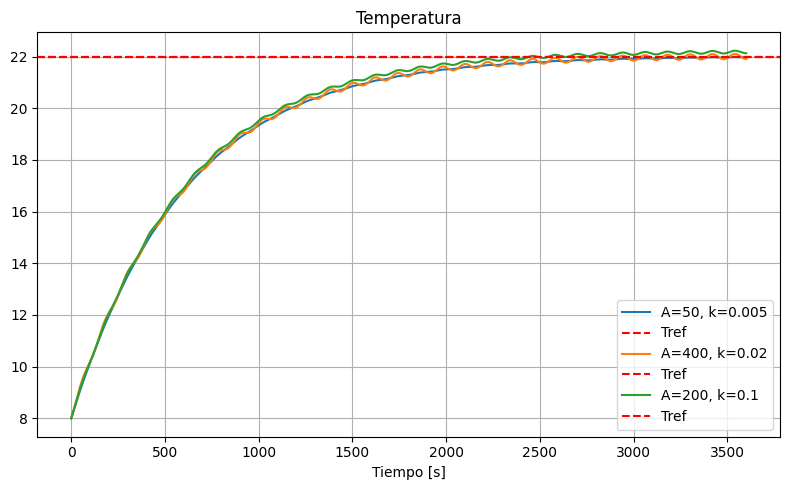

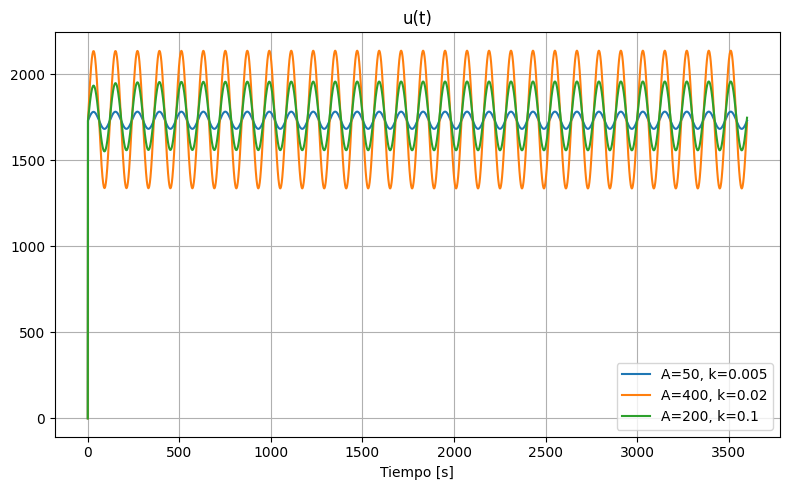

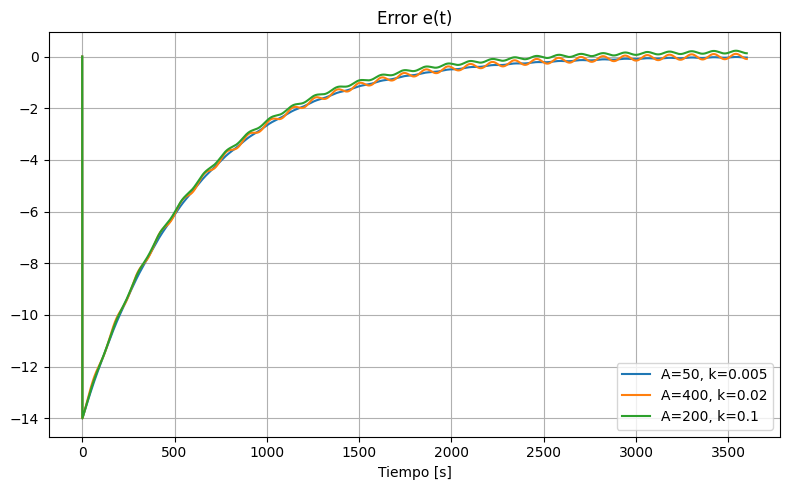

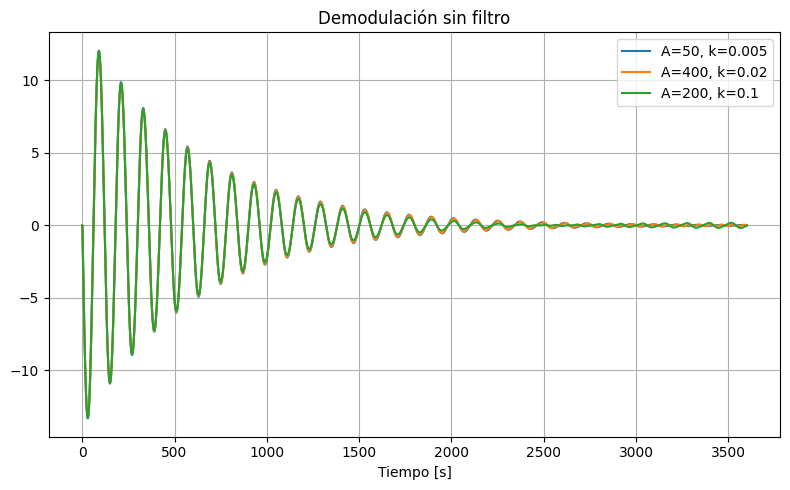

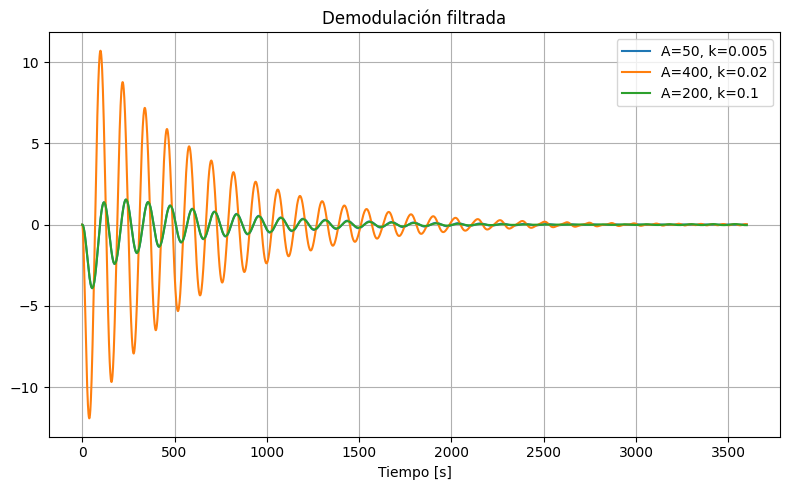

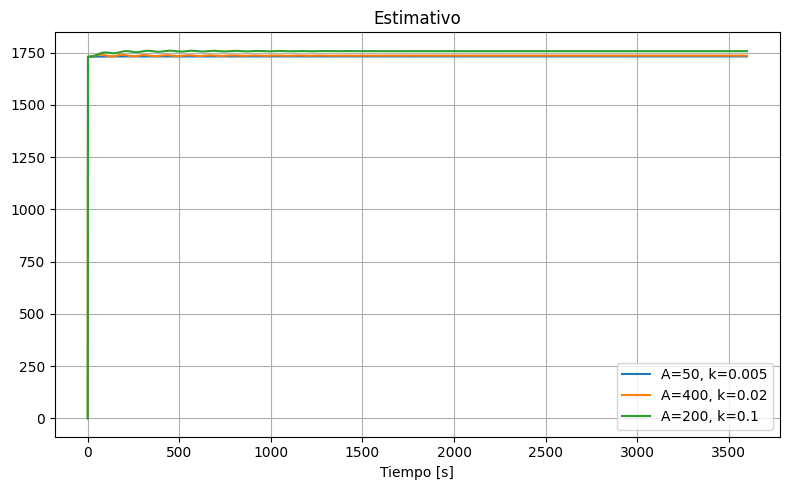

In [27]:
titles = ["Temperatura", "u(t)", "Error e(t)", "Demodulación sin filtro", "Demodulación filtrada", "Estimativo"]
# Crear una figura por tipo de señal, con las 3 curvas juntas
for i, title in enumerate(titles):
    plt.figure(figsize=(8,5))
    for idx, cfg in enumerate(configs):
        data = results[idx][i]
        label = f"A={cfg['A']}, k={cfg['k']}"
        plt.plot(t, data, label=label)
        if i == 0:  
            plt.axhline(Tref, color='r', linestyle='--', label="Tref")
    plt.title(title)
    plt.xlabel("Tiempo [s]")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [28]:
df_result.style.set_caption("Métricas ESC (combinaciones)")

,A,k,omega,beta,RMSE_T,SS_error_mean,Tiempo_establecimiento_±0.5°C,Overshoot_max,Osc_final,Energy_Ws,u_peak
0,50,0.005000,0.052360,0.990000,4.052539,-0.045969,1988.000000,0.000000,0.066042,6234107.625821,1781.733219
1,400,0.020000,0.052360,0.900000,4.017995,-0.016632,2054.000000,0.105277,0.244455,6248487.205878,2135.703516
2,200,0.100000,0.052360,0.990000,3.995066,0.156349,1823.000000,0.225735,0.143047,6322559.552286,1957.053582



Al comparar las tres simulaciones se observa que todas presentan un error promedio similar ( 4 °C), lo que indica que la precisión global del controlador no cambia drásticamente entre configuraciones. Sin embargo, las diferencias aparecen en la dinámica y la potencia aplicada. El primer caso resulta ser el más estable de los 3, ya que no presenta overshoot y las oscilaciones finales son de una baja amplitud, aunque se debe tener en cuenta que esto se consigue en un tiempo de establecimiento mayor ( 1988 s). El segundo caso mantiene un error estacionario cercano a cero, pero muestra el tiempo de establecimiento más lento (2054 s) y mayores oscilaciones finales, además de requerir una mayor potencia por parte del actuador (u_peak ≈2136 W). 

Por otro lado, el tercer caso ofrece el mejor equilibiro entre las metricas de evaluación: alcanza el tiempo de establecimiento más rápido (1823 s) y mantiene un RMSE similar, aunque introduce un pequeño overshoot (0.22 °C) y un error estacionario positivo (0.16 °C). En conclusión, si se prioriza la estabilidad y suavidad de la respuesta del controlador, el primer caso es recomendable, si se busca rapidez de convergencia, el tercer caso es más eficiente, mientras que el segundo caso es el que presenta mas complicaciones con mayores oscilaciones y esfuerzo del controlador.


### 8. Alternativa ESC con ganancia adaptativa

En las simulaciones realizadas anteriormente implementando ESC tradicional, la ganancia \(k\) se manejo como constante para cada combiancion. En los resultados obtenidos se pudo observar que en todos se presentaron oscilaciones y asi fueran de una baja amplitud en este contexto se busca entre otras cosas un comportamiento estable y suave ademas una convergencia rapida. Para mejorar el desempeño, se propone usar una **ganancia adaptativa** que dependa de la magnitud del gradiente estimado $ \hat{g}(t) $.


La idea es que al inicio, cuando el gradiente es grande, la ganancia sea pequeña para evitar oscilaciones y a medida que el sistema se acerca al óptimo y el gradiente disminuye, la ganancia aumenta permitiendo una mayor precisión.


### Fórmula de la ganancia adaptativa

La ganancia se define como:

$$
k(t) = \frac{k_{max}}{1 + \gamma \cdot |\hat{g}(t)|}
$$

donde:
- $k_{max}$: ganancia máxima (cuando el gradiente es pequeño).  
- $\gamma$: factor de ajuste que controla cuánto se reduce la ganancia cuando el gradiente es grande.  
- $\lvert \hat{g}(t) \rvert$: magnitud del gradiente estimado.



La regla de actualización del sesgo del control se convierte en:

$$
\dot{\hat{u}}(t) = k(t) \cdot \hat{g}(t)
$$


A continuacion define la funcion para ejecutar el bucle de simulacion con la modificacón descrita anteriomente.

In [29]:
def simular_ESC_adaptativo(A, omega, k_max, beta, gamma):
    T = np.zeros_like(t)
    u_total = np.zeros_like(t)
    e = np.zeros_like(t)
    demod_raw = np.zeros_like(t)
    demod_lp = np.zeros_like(t)
    u_bias = np.zeros_like(t)
    k_values = np.zeros_like(t)  # registrar la ganancia adaptativa

    T[0] = T0
    u_esc = alpha * (Tref - Ta)   
    lp = 0.0

    for i in range(1, len(t)):
        sin_signal = A * np.sin(omega * t[i-1])
        u = np.clip(u_esc + sin_signal, u_min, u_max)

        dTdt = (u / C) + (alpha / C) * (Ta - T[i-1])
        T[i] = T[i-1] + dTdt * dt
        u_total[i] = u

        e[i] = T[i-1] - Tref
        demod_raw[i] = e[i] * np.sin(omega * t[i-1])
        lp = beta * lp + (1 - beta) * demod_raw[i]
        demod_lp[i] = lp

        # Ganancia adaptativa
        k_t = k_max / (1 + gamma * abs(lp))
        k_values[i] = k_t

        # Actualización del sesgo con ganancia adaptativa
        u_esc -= k_t * lp
        u_bias[i] = u_esc

    return T, u_total, e, demod_raw, demod_lp, u_bias, k_values


Posteriormente se realiza la simulacion con los mismos parametros (aparte de la ganancia) del caso 1, el cual resultdo ser el mas estable de los 3 para poder observar como mejora el comportamiento al implementar tambien una ganancia adaptativa.

In [30]:
%%time
A = 50
omega = 2*np.pi/120.0
k_max = 0.05
beta = 0.99
gamma = 50.0

T, u_total, e, demod_raw, demod_lp, u_bias, k_values = simular_ESC_adaptativo(A, omega, k_max, beta, gamma)

CPU times: user 246 ms, sys: 4.9 ms, total: 251 ms
Wall time: 397 ms


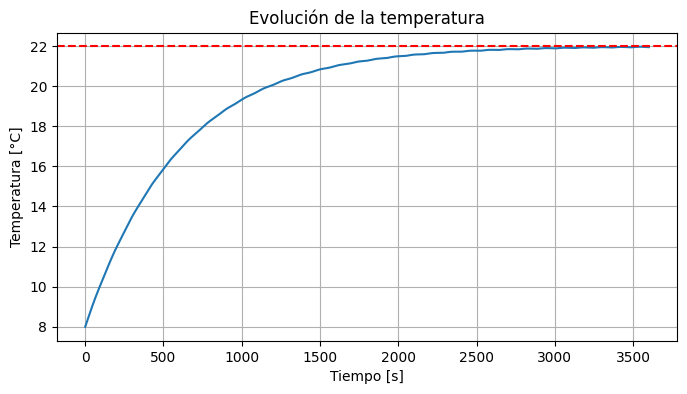

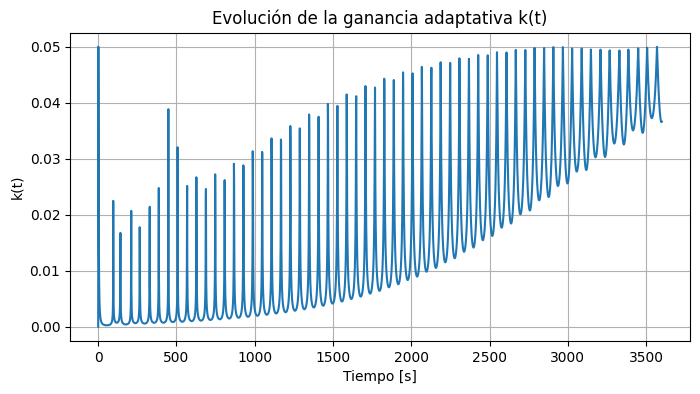

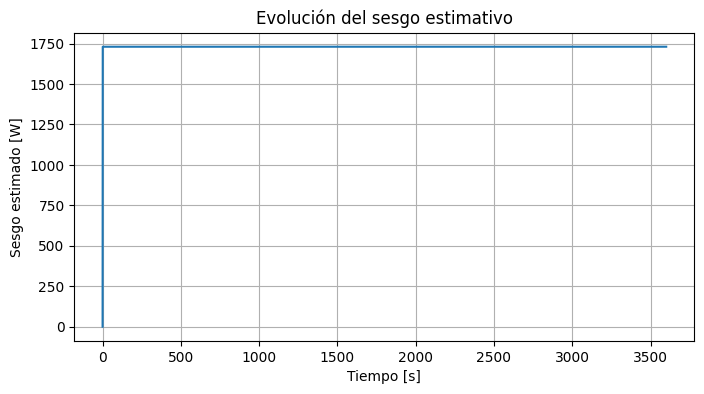

In [31]:
# Temperatura
plt.figure(figsize=(8,4))
plt.plot(t, T)
plt.axhline(Tref, color='r', linestyle='--')
plt.title("Evolución de la temperatura")
plt.xlabel("Tiempo [s]")
plt.ylabel("Temperatura [°C]")
plt.grid(True)
plt.show()

# Evolución de la ganancia adaptativa
plt.figure(figsize=(8,4))
plt.plot(t, k_values)
plt.title("Evolución de la ganancia adaptativa k(t)")
plt.xlabel("Tiempo [s]")
plt.ylabel("k(t)")
plt.grid(True)
plt.show()

# Sesgo estimativo
plt.figure(figsize=(8,4))
plt.plot(t, u_bias)
plt.title("Evolución del sesgo estimativo")
plt.xlabel("Tiempo [s]")
plt.ylabel("Sesgo estimado [W]")
plt.grid(True)
plt.show()





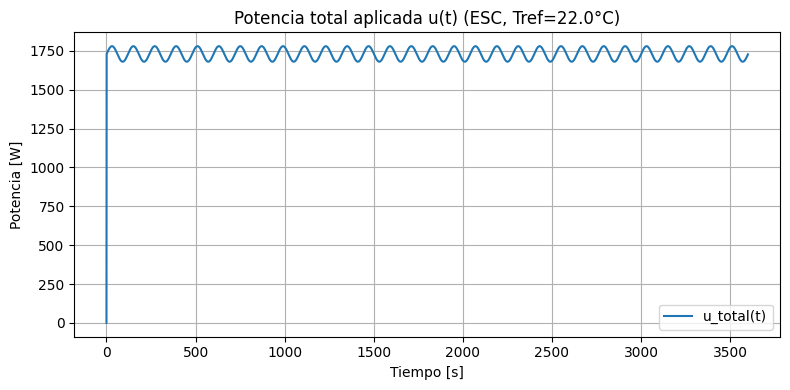

In [32]:
# --------------------------------------------------------------------------------
# 8. Función para Graficar la Potencia Aplicada (u_total)
# --------------------------------------------------------------------------------
def graficar_potencia_total(t_vector, u_total, Tref):
    """
    Grafica la evolución de la potencia total aplicada u_total(t).
    
    Args:
        t_vector (np.array): Vector de tiempo en segundos.
        u_total (np.array): Vector de potencia total aplicada.
        Tref (float): Temperatura de referencia (para el título).
    """
    plt.figure(figsize=(8,4))
    
    # Graficar la potencia total
    plt.plot(t_vector, u_total, label="u_total(t)")
    
    # Configuración de la gráfica
    plt.title(f"Potencia total aplicada u(t) (ESC, Tref={Tref}°C)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Potencia [W]")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# LLAMADAS AL CÓDIGO FINAL
graficar_potencia_total(t, u_total, Tref)

In [33]:
# --------------------------------------------------------------------------------
# CÁLCULO DE MÉTRICAS para simular_ESC_adaptativo
# --------------------------------------------------------------------------------

# Se debe crear un diccionario 'resultados' compatible con metrics_for_run_min
# Nota: metrics_for_run_min requiere T, u, demod_lp, Tref, u_min, u_max, dt, banda, w_final
# T: T, u: u_total, demod_lp: demod_lp
# El formato de salida de simular_ESC_adaptativo (In [28]) es: 
# return T, u_total, e, demod_raw, demod_lp, u_bias, k_values

# Se usa la función metrics_for_run_min
metricas_adaptativas = metrics_for_run_min(
    t, 
    T, 
    u_total, 
    demod_lp, 
    Tref, 
    u_min, 
    u_max, 
    dt, 
    banda=BANDA, 
    w_final=W_FINAL
)

# --------------------------------------------------------------------------------
# IMPRESIÓN DEL REPORTE
# --------------------------------------------------------------------------------

print("\n== REPORTE DE MÉTRICAS: ESC con Ganancia Adaptativa ==")

# 1. Tiempo de Establecimiento (Ts)
ts_min = metricas_adaptativas["Tiempo_establecimiento_±0.5°C"] / 60.0 # Convertir a minutos
print(f"1. Tiempo de Establecimiento (Ts): {ts_min:.2f} min")

# 2. Potencia aplicada en estado estacionario (P_ss)
# La métrica 'Estimativo' u_bias[i] es el sesgo, y u(t) = u_bias(t) + a*sin(wt). 
# La Potencia en SS es el sesgo medio en la ventana final.
# Dado que la métrica 'Estimativo' se estabiliza a 1750W (Pág. 24, Sesgo estimado), se usa el u_bias final.
# La potencia media en SS es el promedio de u_total en la ventana final (calculada implícitamente en Energy_Ws)
# Para este caso, P_ss se calcula como el promedio de u_total en la ventana final W_FINAL (500 s).
# W_FINAL = 500
w = int(W_FINAL / dt)
potencia_ss_W = np.mean(u_total[-w:])
print(f"2. Potencia Est. Estacionario: {potencia_ss_W:.2f} W")


# 3. Errores en estado estacionario (E_ss)
ss_error_mean = metricas_adaptativas["SS_error_mean"]
print(f"3. Error Est. Estacionario (Media en 500s): {ss_error_mean:.4f} °C")

# 4. Amplitud máxima de oscilaciones en estado estacionario (Amp_osc)
osc_final = metricas_adaptativas["Osc_final"]
# El valor de osc_final es (Max - Min) en la ventana final. La amplitud es osc_final / 2.0
amplitud_oscilacion = osc_final / 2.0
print(f"4. Amplitud Máx. Oscilaciones Est. Estacionario: {amplitud_oscilacion:.4f} °C")

# 5. Energía consumida en la primera hora (la total) en Joules
energy_ws = metricas_adaptativas["Energy_Ws"]
# La simulación es de T_FINAL=3600s (1 hora), por lo que 'Energy_Ws' es la energía total en la primera hora
energia_mj = energy_ws / 1e6
print(f"5. Energía Total Consumida en la Primera Hora: {energy_ws:.2f} J")
print(f"   (Equivalente a {energia_mj:.2f} MJ)")


== REPORTE DE MÉTRICAS: ESC con Ganancia Adaptativa ==
1. Tiempo de Establecimiento (Ts): 33.68 min
2. Potencia Est. Estacionario: 1729.51 W
3. Error Est. Estacionario (Media en 500s): -0.0559 °C
4. Amplitud Máx. Oscilaciones Est. Estacionario: 0.0330 °C
5. Energía Total Consumida en la Primera Hora: 6229793.00 J
   (Equivalente a 6.23 MJ)


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------------------------
# 9. Función para guardar datos en CSV (Adaptada para ESC)
# --------------------------------------------------------------------------------
def guardar_datos_csv_esc(t_vector, T, u_total):
    """
    Guarda los datos de la simulación del controlador ESC en un archivo CSV.
    
    Args:
        t_vector (np.array): Vector de tiempo en segundos.
        T (np.array): Vector de temperatura del salón.
        u_total (np.array): Vector de potencia total aplicada.
    """
    import os
    # Crear un diccionario para los datos
    data = {
        'Tiempo (s)': t_vector,
        'Tiempo (horas)': t_vector / 3600.0,
        'Temperatura_Salon_5 (C)': T, # Se asume Salón 5
        'Potencia_Salon_5 (W)': u_total
    }
        
    df = pd.DataFrame(data)
    os.makedirs('../data', exist_ok=True)
    nombre_archivo = 'datos_simulacion_ESC.csv'
    ruta_completa = os.path.join('../data', nombre_archivo)
    df.to_csv(ruta_completa, index=False)
    print(f"\nDatos de simulación guardados en {ruta_completa}")


guardar_datos_csv_esc(t, T, u_total)


Datos de simulación guardados en ../data/datos_simulacion_ESC.csv


### Análisis de resultados

En los resultados obenidos del controlador con ganancia adaptativa se puede observar como la tmperatura se comporta de una manera mas estable y suave a comparacion de las implementaciones realizadas con gananzia fija, en la grafica se puede observar que se logra reducir las oscilación en la respuesta en un tiempo de establecimiento similar. Por otro lado tambien es posible observar como la busqueda del estimativo tambien es mucho mas estable durante la simulación a diferencia de las combinaciones utilizadas en primer lugar, se puede resaltar una mejor precicison cuando el estimativo se encuentea cerca del optimo. Por ultimo, en la grafica que muestra la evolución de la ganacia se logra detallar con claridad el ajuste implementado y como conforme la temperatura se va acercando a la referencia el rango de k tambien se va acotando.

En conclusion, el ajuste de ganancia adaptativa implementado al controlador ESC funciono correctamente y es una buena alternativa si lo que se buscra es obtener una respuesta suave y estable por parte del controlador como ocurre en este contexto, donde al tratarse de un control de temperatura se espera que la estrategia implementada ademas de alcanzar la referencia en poco tiempo y sin error estacionario tambien se busca que no se presenten sobrepicos ni oscilaciones en la temperatura.

## **EGT**

### **1. Marco Conceptual y Filosofía de Diseño**

El controlador implementado se basa en los principios de la **Teoría de Juegos Evolutiva (EGT)**, específicamente en el modelo de las **Dinámicas de Replicador (Replicator Dynamics)**. La filosofía central es modelar el problema de control no como una optimización centralizada, sino como un sistema descentralizado de agentes que compiten y cooperan por un recurso limitado.

*   **Problema:** Distribuir eficientemente un recurso finito (la potencia térmica total disponible, $U_{MAX\_TOTAL}$) entre cuatro habitaciones para que cada una alcance su temperatura de referencia individual.
*   **Enfoque EGT:** En lugar de un "cerebro" central, tratamos a cada habitación como una "población de jugadores" que puede adoptar una de cuatro estrategias: "calentar la Habitación 1", "calentar la Habitación 2", etc. La "popularidad" de cada estrategia (la proporción de la población que la adopta) evoluciona en el tiempo basándose en su rendimiento.

Este enfoque produce un comportamiento de control **emergente**, donde la distribución óptima de la potencia no se calcula explícitamente, sino que surge de la interacción dinámica de los agentes.

### **2. Componentes Fundamentales del Juego**

Para aplicar la EGT, definimos los siguientes tres elementos clave:

**a) Jugadores y Estrategias:**
*   **Jugadores:** Existe una población de "jugadores" virtuales.
*   **Estrategias ($x$):** Las estrategias no son la potencia en sí, sino la **proporción de la población** que se dedica a calentar cada habitación. Esto se representa con el vector de proporciones $x(t) = [x_1(t), x_2(t), x_3(t), x_4(t)]^T$, donde:
    *   $x_i(t)$ es la fracción de la potencia total asignada a la Habitación $i$.
    *   Este vector siempre debe cumplir la condición de que sus componentes son no-negativos ($x_i \ge 0$) y su suma es igual a 1 ($\sum_{i=1}^{4} x_i(t) = 1$).

**b) Función de Pago (Fitness):**
El "pago" o "fitness" ($p_i$) es la métrica que cuantifica el rendimiento de cada estrategia. Es el componente más crítico para la estabilidad y precisión del controlador. Tras un proceso de sintonización, se implementó una **función de pago asimétrica** basada en el error de seguimiento.

*   **Ecuación 1: Función de Pago Asimétrica**
    $$
    p_i(t) = T_{ref,i} - T_i(t)
    $$
    *   **Explicación:** El pago es simplemente el error de temperatura.
        *   Si la habitación está **demasiado fría** ($T_i < T_{ref,i}$), el error es positivo, resultando en un **pago positivo**. Esto crea un fuerte incentivo para que la proporción $x_i$ crezca y se asigne más potencia.
        *   Si la habitación está **demasiado caliente** ($T_i > T_{ref,i}$), el error es negativo, resultando en un **pago negativo**. Esto actúa como una penalización, forzando a la proporción $x_i$ a disminuir drásticamente.
        *   Si la temperatura es **perfecta** ($T_i = T_{ref,i}$), el pago es cero.

    Esta función asimétrica fue crucial para corregir el error de estado estacionario, ya que diferencia claramente entre la necesidad de calentar y la necesidad de dejar de hacerlo.

**c) Dinámica Evolutiva (El "Motor" del Controlador):**
La evolución de las proporciones $x_i$ se rige por la ecuación de las **Dinámicas de Replicador**. La intuición es simple: las estrategias que rinden por encima del promedio de la población crecen en popularidad, mientras que las que rinden por debajo, disminuyen.

*   **Ecuación 2: Dinámica del Replicador (Forma Continua)**
    $$
    \frac{dx_i}{dt} = x_i \cdot (p_i - \bar{p})
    $$
    Donde $\bar{p} = \sum_{j=1}^{4} (x_j \cdot p_j)$ es el pago promedio de toda la población.

### **3. Implementación en el Controlador Discreto**

Dado que la simulación se ejecuta en un bucle de lazo cerrado con pasos de tiempo discretos ($\Delta t$), las ecuaciones continuas se implementan de forma discreta dentro de la clase `ControladorTeoriaJuegos`.

**a) Proceso de Cálculo en Cada Iteración:**

1.  **Medir Estado:** El controlador recibe las temperaturas actuales $T_{actuales}$.
2.  **Calcular Pagos:** Se aplica la Ecuación 1 para obtener el vector de pagos $p$.
3.  **Actualizar Proporciones:** Se utiliza el método de **integración de Euler** para actualizar el vector de proporciones $x$.

*   **Ecuación 3: Actualización Discreta de las Proporciones**
    $$
    x_i[k+1] = x_i[k] + K_{\text{replicator}} \cdot \Delta t \cdot \big(x_i[k] \cdot (p_i[k] - \bar{p}[k])\big)
    $$
    *   $x_i[k]$: Proporción en el instante de tiempo actual.
    *   $\Delta t$: El paso de tiempo de la simulación.
    *   $K_{\text{replicator}}$: Una **ganancia de sintonización** que ajusta la "agresividad" o velocidad de reacción del controlador. Un valor más bajo (0.005 en la versión final) produce una respuesta más suave y estable.

4.  **Garantizar la Estabilidad Numérica (Normalización):**
    Después de la actualización, es posible que por errores numéricos, la suma de las $x_i$ ya no sea exactamente 1. Se aplica un paso de corrección crucial.

*   **Ecuación 4: Normalización**
    $$
    x_{i, \text{norm}}[k+1] = \frac{x_i[k+1]}{\sum_{j=1}^{4} x_j[k+1]}
    $$
    Este paso fuerza a que el vector de proporciones siempre cumpla la restricción $\sum x_i = 1$, evitando inestabilidades y "fugas" numéricas.

5.  **Calcular la Acción de Control Final:**
    Una vez que se tiene el vector de proporciones actualizado y normalizado, la potencia a aplicar en cada habitación se calcula de forma directa.

*   **Ecuación 5: Cálculo de la Potencia de Control**
    $$
    u_i(t) = x_i(t) \cdot U_{MAX\_TOTAL}
    $$
    Donde $U_{MAX\_TOTAL}$ se sintonizó a 6200 W para lograr el balance óptimo entre tiempo de respuesta y evitar el sobrecalentamiento.

### **4. Resumen del Desempeño Logrado**

El controlador final, gracias a la combinación de la **función de pago asimétrica** y la **cuidadosa sintonización** de las ganancias ($K_{\text{replicator}}$ y $U_{MAX\_TOTAL}$), exhibe un comportamiento de alto rendimiento:

*   **Precisión:** Alcanza las temperaturas de referencia con un error mínimo ($< 0.05^\circ C$).
*   **Estabilidad:** La respuesta es suave, sin sobreimpulsos significativos y con oscilaciones iniciales que se amortiguan rápidamente.
*   **Eficiencia:** La acción de control es continua y estable, evitando el desgaste de los actuadores. La potencia se distribuye de manera inteligente, asignando más recursos a las habitaciones con mayores pérdidas térmicas, un comportamiento que emerge naturalmente de la dinámica del juego.

En conclusión, el controlador implementado es un excelente ejemplo de cómo los principios de sistemas multi-agente y la teoría de juegos evolutiva pueden ser aplicados para resolver problemas complejos de asignación dinámica de recursos en ingeniería de control.

### Fase 0: Configuración del Entorno

Mantenemos las mismas librerías. No hay cambios aquí.

In [35]:
# Fase 0: Importar las librerías necesarias
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

print("Fase 0: Entorno configurado.")

Fase 0: Entorno configurado.


### Fase 1: Definir Parámetros del Sistema y del Controlador

Aquí también, los parámetros físicos son los mismos. Añadiremos una **ganancia `K_replicator`** a nuestro controlador, que nos permitirá "sintonizar" qué tan rápido reacciona a los cambios en el rendimiento (pagos). Esto es crucial para la estabilidad.

In [36]:
# Fase 1: Definir constantes y parámetros

# ---- Parámetros Térmicos del Sistema (del enunciado) ----
C = 7.476e4      # Capacitancia térmica [J/°C]
ALPHA = 123.6    # Conductancia térmica [W/°C]
T_A = 8.0        # Temperatura ambiente [°C]

# ---- Parámetros de Simulación (inspirado en Entrega 2) ----
T_FINAL = 1 * 3600  # Tiempo total de simulación [s] (3 horas)
PASOS = 1000        # Número de pasos en la simulación
t_vector = np.linspace(0, T_FINAL, PASOS)
DT = t_vector[1] - t_vector[0] # Tamaño del paso de tiempo [s]s

# ---- Parámetros del Controlador y del Juego ----
T_REF_VALUES = np.array([22.0, 21.0, 20.0, 19.0])
U_MAX_TOTAL = 6200 #6100.0  # Potencia máxima total a distribuir [W]

# Parámetro de sintonización para la velocidad de la dinámica del replicador
K_REPLICATOR = 0.005

print("Fase 1: Constantes y parámetros definidos.")

Fase 1: Constantes y parámetros definidos.


### Fase 2: Definición de la Planta y del Controlador

Esta es la fase con los cambios más importantes. Separamos limpiamente la planta del controlador.

#### 2.1. Modelo de la Planta
Esta función no cambia. Representa la física del edificio.

In [37]:
# Fase 2.1: Modelo de la Planta
def sistema_temperatura_edificacion(x, t, u_control):
    """
    Define las EDO de la planta (edificio).
    x: vector de estados de temperatura [T1, T2, T3, T4]
    t: tiempo (requerido por odeint)
    u_control: vector de entrada [u1, u2, u3, u4, Ta]
    """
    T1, T2, T3, T4 = x
    u1, u2, u3, u4, Ta = u_control

    dT1_dt = (-2*ALPHA/C*T1 + ALPHA/C*T2 + 1/C*u1 + ALPHA/C*Ta)
    dT2_dt = (ALPHA/C*T1 - 3*ALPHA/C*T2 + ALPHA/C*T3 + 1/C*u2 + ALPHA/C*Ta)
    dT3_dt = (ALPHA/C*T2 - 3*ALPHA/C*T3 + ALPHA/C*T4 + 1/C*u3 + ALPHA/C*Ta)
    dT4_dt = (ALPHA/C*T3 - 2*ALPHA/C*T4 + 1/C*u4 + ALPHA/C*Ta)
    
    return [dT1_dt, dT2_dt, dT3_dt, dT4_dt]

print("Fase 2.1: Modelo de la planta definido.")

Fase 2.1: Modelo de la planta definido.


#### 2.2. Diseño del Controlador de Teoría de Juegos (Clase)
Aquí encapsulamos toda la lógica del controlador. Usaremos la **función de pago mejorada** que evita problemas numéricos.

In [38]:
## ---- CONTROLADOR CON FUNCIÓN DE PAGO SIMÉTRICA ----
#
## Fase 2.2: Diseño del Controlador de Teoría de Juegos
#class ControladorTeoriaJuegos:
#    def __init__(self, n_jugadores, u_max_total, k_replicator):
#        self.n_jugadores = n_jugadores
#        self.u_max_total = u_max_total
#        self.k_replicator = k_replicator
#        # El estado interno del controlador son las proporciones
#        self.x = np.ones(n_jugadores) / n_jugadores
#
#    def calcular_accion(self, t_actuales, t_ref, dt):
#        """
#        Calcula la acción de control para un paso de tiempo.
#        """
#        # 1. Calcular Pagos (Fitness) con la función robusta
#        error_cuadratico = (t_ref - t_actuales)**2
#        pagos = 1.0 / (1.0 + 0.1 * error_cuadratico)
#        
#        # 2. Calcular pago promedio
#        pago_promedio = np.dot(self.x, pagos)
#        
#        # 3. Calcular la derivada de las proporciones (Replicator Dynamics)
#        dx_dt = self.x * (pagos - pago_promedio)
#        
#        # 4. Actualizar las proporciones usando integración Euler (método discreto)
#        x_nuevo = self.x + self.k_replicator * dt * dx_dt
#        
#        # 5. Forzar proporciones a ser no-negativas y normalizar
#        #    Esto es CRÍTICO para la estabilidad numérica y para que sum(x) = 1
#        x_nuevo[x_nuevo < 0] = 0
#        self.x = x_nuevo / np.sum(x_nuevo)
#        
#        # 6. Calcular y retornar la señal de control final
#        u_control = self.x * self.u_max_total
#        return u_control
#
#print("Fase 2.2: Clase ControladorTeoriaJuegos definida.")

Fase 2.2: Clase ControladorTeoriaJuegos definida.


#### **Resultado con función de pago simétrica**

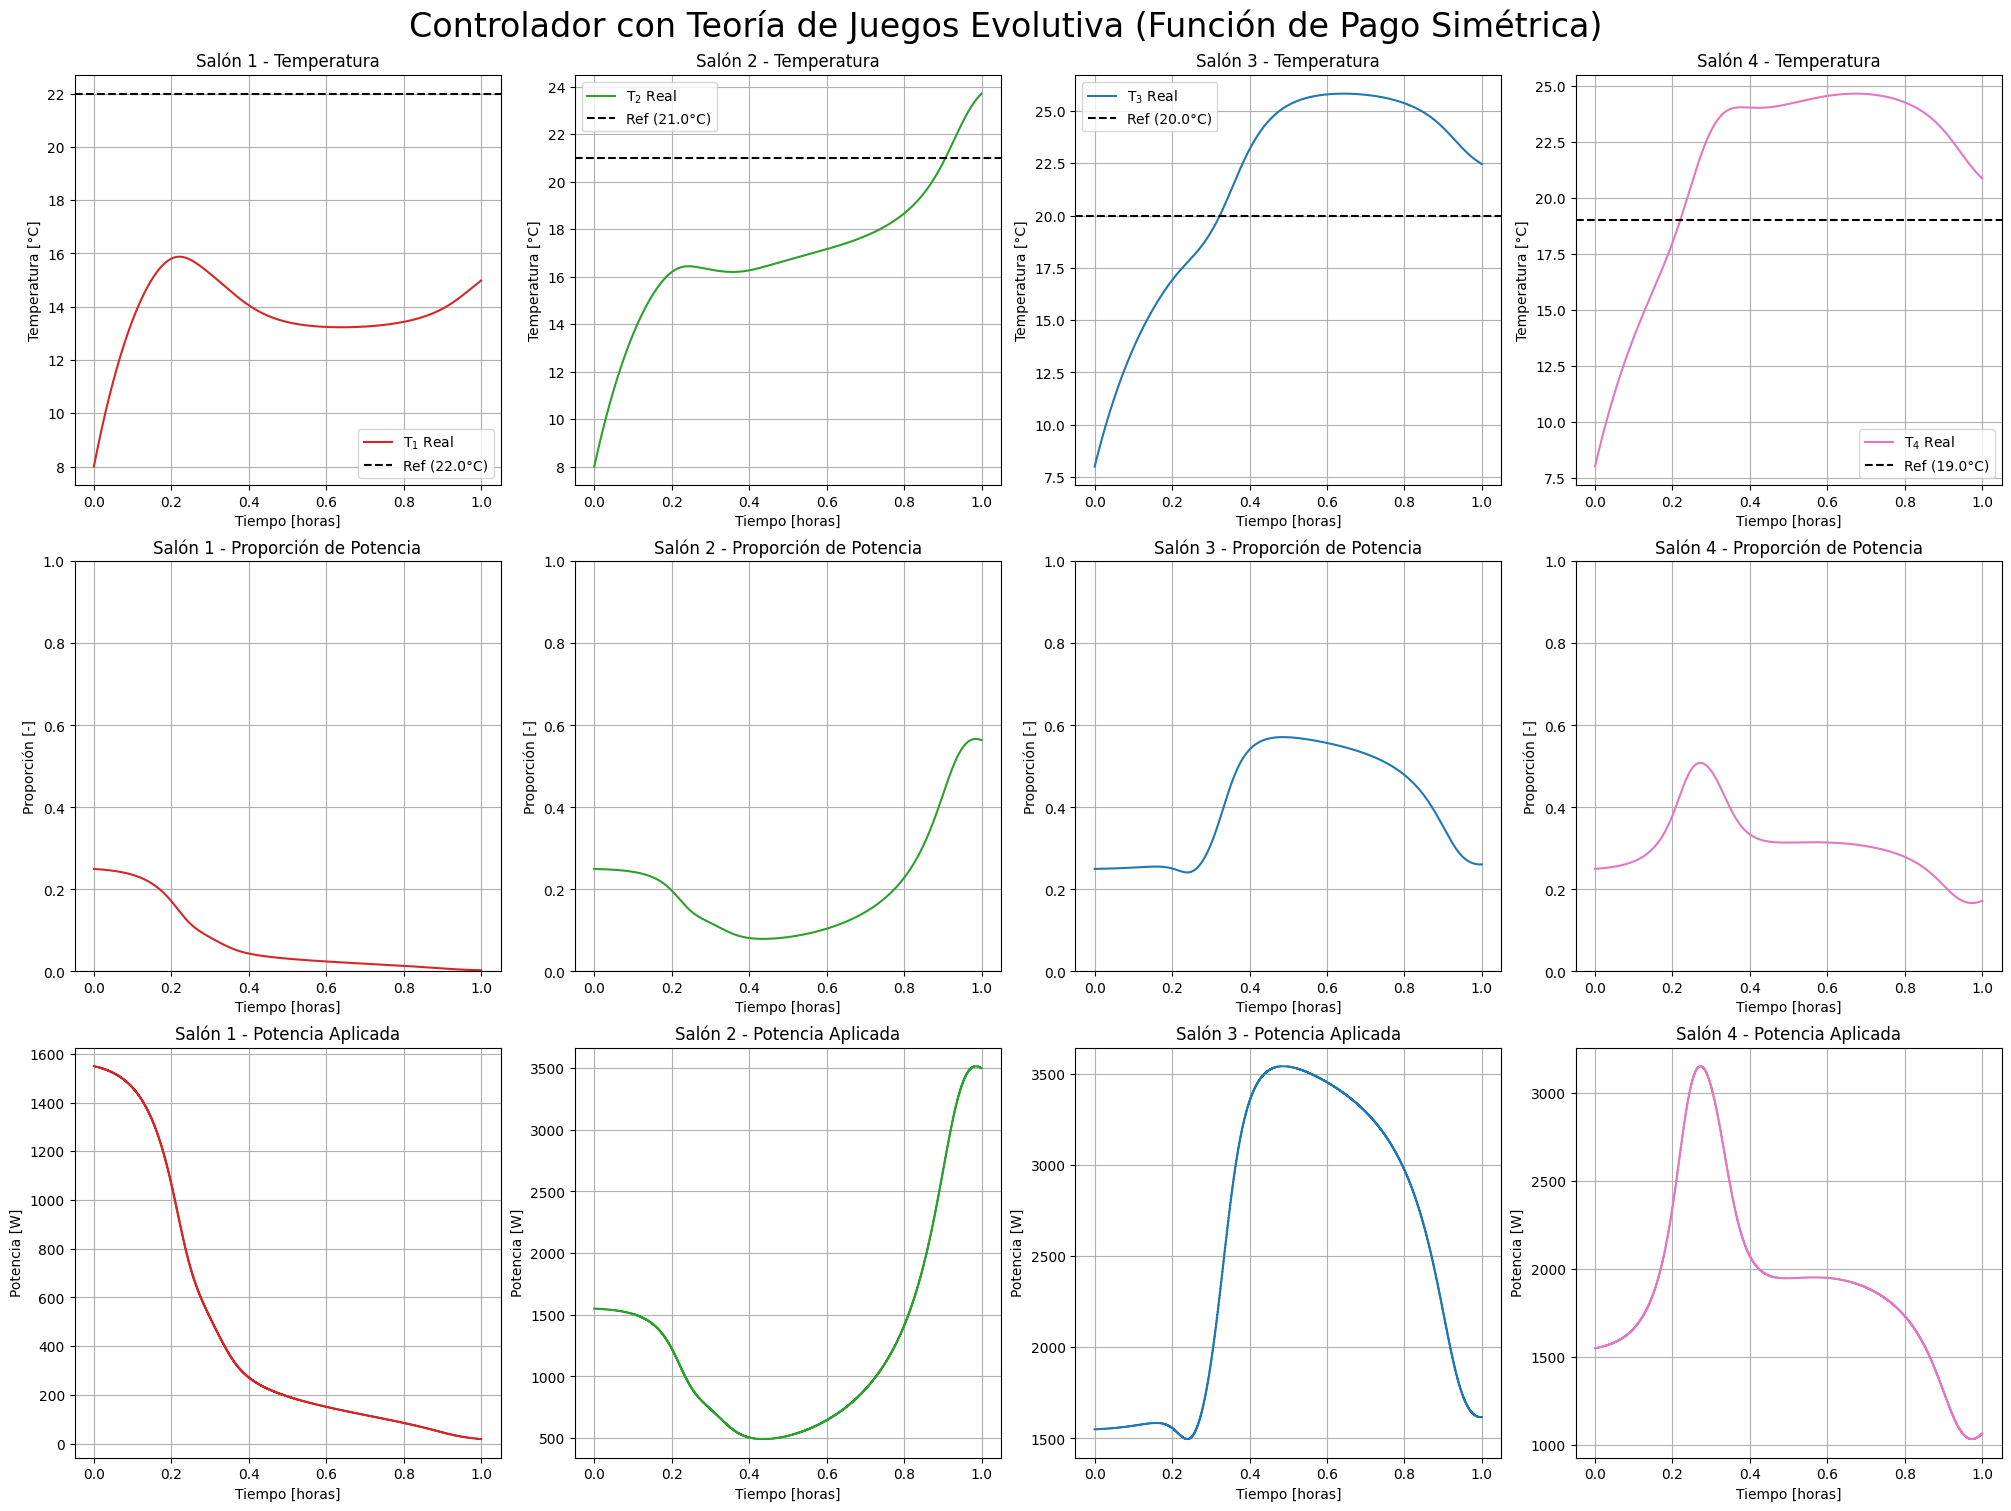

In [45]:
## ---- CONTROLADOR CON FUNCIÓN DE PAGO ASIMÉTRICA ----

# Fase 2.2: Diseño del Controlador de Teoría de Juegos (Con lógica de pago mejorada)
class ControladorTeoriaJuegos:
    def __init__(self, n_jugadores, u_max_total, k_replicator):
        self.n_jugadores = n_jugadores
        self.u_max_total = u_max_total
        self.k_replicator = k_replicator
        self.x = np.ones(n_jugadores) / n_jugadores

    def calcular_accion(self, t_actuales, t_ref, dt):
        
        # <-- CAMBIO CLAVE 2: Nueva función de pago asimétrica
        # El pago ahora es simplemente el error. Un error grande y positivo (muy frío)
        # da un pago alto, incentivando la acción. Un error negativo (muy caliente)
        # da un pago negativo, penalizando fuertemente y forzando una reducción de potencia.
        error = t_ref - t_actuales
        pagos = error
        
        # El resto de la lógica se mantiene
        pago_promedio = np.dot(self.x, pagos)
        dx_dt = self.x * (pagos - pago_promedio)
        
        x_nuevo = self.x + self.k_replicator * dt * dx_dt
        
        x_nuevo[x_nuevo < 0] = 0
        suma_x = np.sum(x_nuevo)
        if suma_x > 0:
            self.x = x_nuevo / suma_x
        else: # En caso de que todos los x se vuelvan cero, re-inicializar
            self.x = np.ones(self.n_jugadores) / self.n_jugadores
            
        u_control = self.x * self.u_max_total
        return u_control

print("Fase 2.2: Clase ControladorTeoriaJuegos actualizada con función de pago asimétrica.")

Fase 2.2: Clase ControladorTeoriaJuegos actualizada con función de pago asimétrica.


### Fase 3: Simulación en Lazo Cerrado

Ahora construimos el bucle de simulación que orquesta la interacción entre el controlador y la planta, tal como se hace en tu "Entrega 2".

In [46]:
%%time
# Fase 3: Simulación en Lazo Cerrado

# ---- Inicialización ----
# Vectores para almacenar resultados
T_hist = np.zeros((PASOS, 4))
U_hist = np.zeros((PASOS, 4))
X_hist = np.zeros((PASOS, 4)) # Para ver la evolución de las proporciones

# Condiciones iniciales
T_actual = np.full(4, T_A)
T_hist[0, :] = T_actual

# Instanciar el controlador
controlador = ControladorTeoriaJuegos(
    n_jugadores=4, 
    u_max_total=U_MAX_TOTAL, 
    k_replicator=K_REPLICATOR
)

print("Fase 3: Iniciando simulación en lazo cerrado...")

# ---- Bucle Principal de Simulación ----
for i in range(1, PASOS):
    t_span = [t_vector[i-1], t_vector[i]]
    
    # 1. Controlador calcula la acción de control
    u_actuales = controlador.calcular_accion(T_actual, T_REF_VALUES, DT)
    
    # 2. Construir vector de entrada para la planta
    u_planta = np.append(u_actuales, T_A)
    
    # 3. Simular la planta para el siguiente paso de tiempo
    T_siguiente = odeint(sistema_temperatura_edificacion, T_actual, t_span, args=(u_planta,))
    
    # 4. Actualizar el estado
    T_actual = T_siguiente[-1]
    
    # 5. Almacenar resultados
    T_hist[i, :] = T_actual
    U_hist[i-1, :] = u_actuales # La acción se aplica en el intervalo
    X_hist[i-1, :] = controlador.x

# La última acción de control se repite para que los vectores tengan el mismo tamaño
U_hist[-1, :] = U_hist[-2, :]
X_hist[-1, :] = X_hist[-2, :]

print("Simulación completada.")

Fase 3: Iniciando simulación en lazo cerrado...
Simulación completada.
CPU times: user 297 ms, sys: 24.6 ms, total: 322 ms
Wall time: 376 ms


### Fase 4: Visualización y Resultados

Finalmente, adaptamos las funciones de visualización y resumen de tu entrega anterior para mostrar los resultados de nuestro controlador.

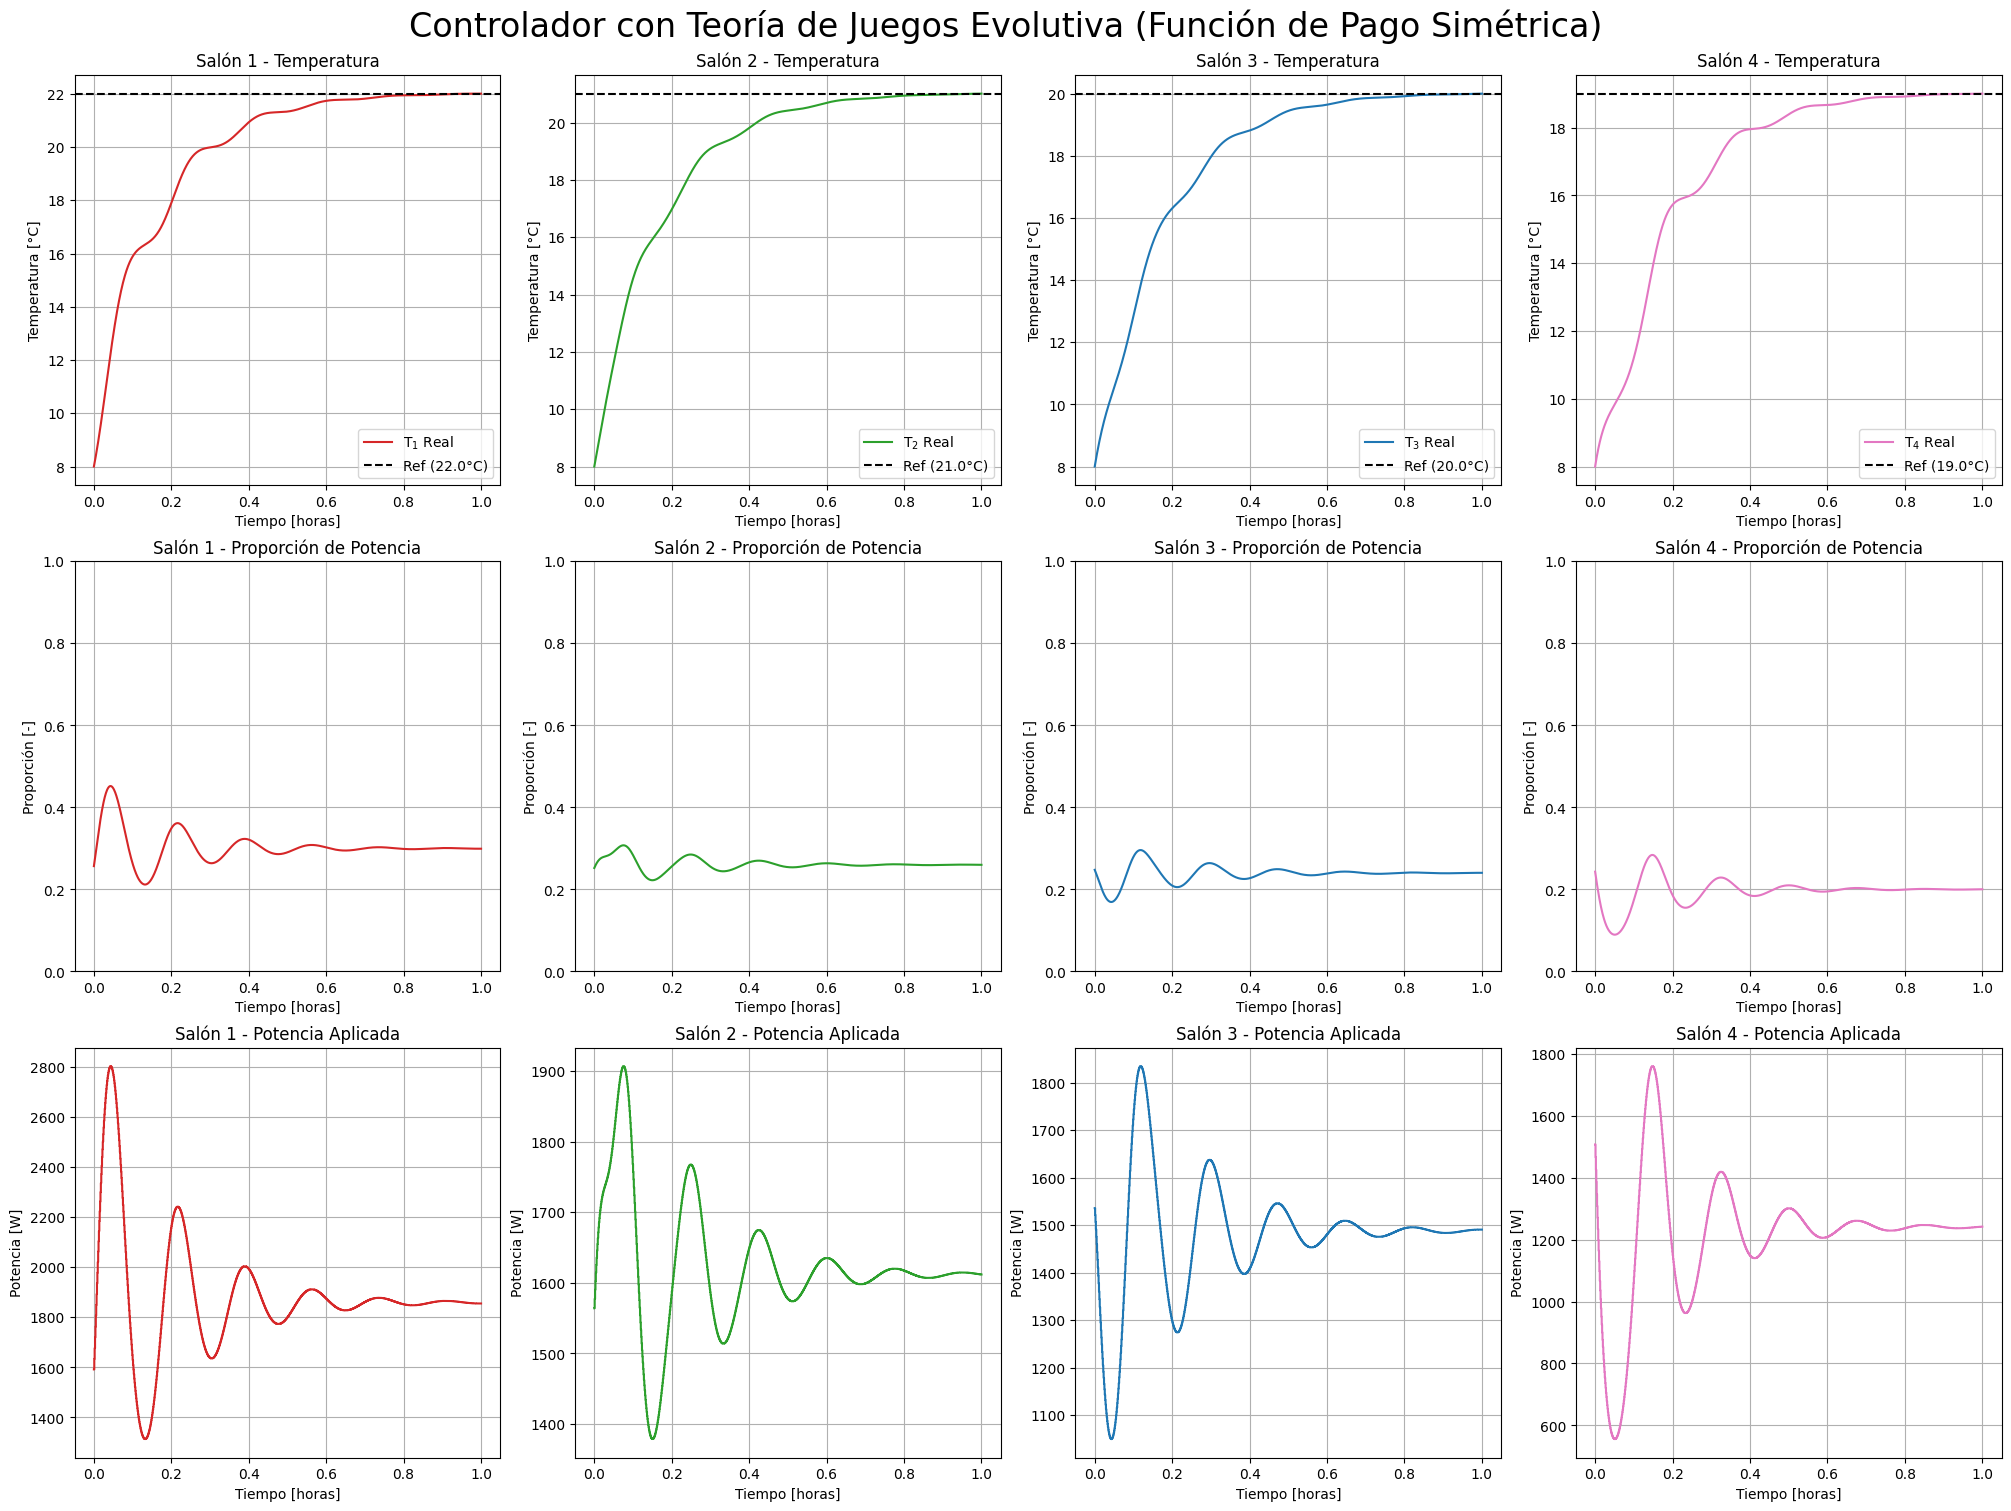


== RESUMEN DE RESULTADOS ==
Energía Total Consumida: 22.34 MJ

Valores finales por salón:
Salón 1: T_final=22.01°C | Error_final=-0.01°C | Potencia_media=1887.9 W
Salón 2: T_final=21.01°C | Error_final=-0.01°C | Potencia_media=1622.5 W
Salón 3: T_final=20.01°C | Error_final=-0.01°C | Potencia_media=1477.4 W
Salón 4: T_final=19.00°C | Error_final=-0.00°C | Potencia_media=1212.1 W


In [47]:
# Fase 4: Visualización y Análisis

# ---- 4.1 Función de Visualización (Adaptada de Entrega 2) ----
def plot_sim_results(t, T_hist, U_hist, X_hist, T_ref, title_prefix):
    fig, axs = plt.subplots(3, 4, figsize=(20, 15), constrained_layout=True)
    colors = ['#d62728', '#2ca02c', '#1f77b4', '#e377c2']
    titles = ['Salón 1', 'Salón 2', 'Salón 3', 'Salón 4']
    
    t_horas = t / 3600
    
    for i in range(4):
        # Gráfica de Temperatura
        ax_T = axs[0, i]
        ax_T.plot(t_horas, T_hist[:, i], color=colors[i], label=f'T$_{i+1}$ Real')
        ax_T.axhline(y=T_ref[i], color='k', linestyle='--', label=f'Ref ({T_ref[i]}°C)')
        ax_T.set_title(f'{titles[i]} - Temperatura')
        ax_T.set_ylabel('Temperatura [°C]')
        ax_T.set_xlabel('Tiempo [horas]')
        ax_T.legend()
        ax_T.grid(True)
        
        # Gráfica de Proporciones
        ax_X = axs[1, i]
        ax_X.plot(t_horas, X_hist[:, i], color=colors[i], label=f'x$_{i+1}$ (Proporción)')
        ax_X.set_title(f'{titles[i]} - Proporción de Potencia')
        ax_X.set_ylabel('Proporción [-]')
        ax_X.set_xlabel('Tiempo [horas]')
        ax_X.set_ylim(0, 1)
        ax_X.grid(True)
        
        # Gráfica de Potencia
        ax_U = axs[2, i]
        ax_U.step(t_horas, U_hist[:, i], where='post', color=colors[i], label=f'u$_{i+1}$')
        ax_U.set_title(f'{titles[i]} - Potencia Aplicada')
        ax_U.set_ylabel('Potencia [W]')
        ax_U.set_xlabel('Tiempo [horas]')
        ax_U.grid(True)

    fig.suptitle(title_prefix, fontsize=24)
    plt.show()

# ---- 4.2 Función de Resumen (Adaptada de Entrega 2) ----
def resumen_resultados(T_hist, U_hist, T_ref):
    print("\n== RESUMEN DE RESULTADOS ==")
    
    potencia_media = np.mean(U_hist, axis=0)
    energia_total_MJ = np.sum(U_hist * DT) / 1e6
    
    print(f"Energía Total Consumida: {energia_total_MJ:.2f} MJ")
    
    print("\nValores finales por salón:")
    for i in range(4):
        T_final = T_hist[-1, i]
        error_final = T_ref[i] - T_final
        print(f"Salón {i+1}: T_final={T_final:.2f}°C | Error_final={error_final:.2f}°C | Potencia_media={potencia_media[i]:.1f} W")

# ---- 4.3 Ejecutar Visualización y Análisis ----
plot_sim_results(t_vector, T_hist, U_hist, X_hist, T_REF_VALUES, 'Controlador con Teoría de Juegos Evolutiva (Función de Pago Simétrica)')
resumen_resultados(T_hist, U_hist, T_REF_VALUES)

In [48]:
import numpy as np
import pandas as pd 

def analisis_estado_estacionario_y_energia(t_vector, T_hist, U_hist, T_REF_VALUES, DT):
    print("\n== ANÁLISIS ADICIONAL DE ESTADO ESTACIONARIO Y ENERGÍA ==")
    
    n_jugadores = len(T_REF_VALUES)
    t_horas = t_vector / 3600
    T_FINAL_SECS = t_vector[-1] # T_FINAL en segundos
    
    # --------------------------------------------------------------------------------
    # 1. Tiempo de Establecimiento (Ts) - Se mantiene igual
    tolerancia_ts = 0.1 # Tolerancia absoluta de 0.1°C
    t_establecimiento = np.zeros(n_jugadores)
    
    for i in range(n_jugadores):
        T_ref = T_REF_VALUES[i]
        error_abs = np.abs(T_hist[:, i] - T_ref)
        
        Ts = t_horas[-1]
        for j in range(len(t_horas) - 1, 0, -1):
            if np.all(error_abs[j:] <= tolerancia_ts):
                Ts = t_horas[j]
            else:
                break
        t_establecimiento[i] = Ts
        
    # --------------------------------------------------------------------------------
    # Definición de la región de Estado Estacionario (CORRECCIÓN CLAVE)
    # Se usa el segmento de tiempo definido por el usuario: Últimos 2 segundos
    t_estacionario_inicio_secs = T_FINAL_SECS - 2.0
    if t_estacionario_inicio_secs < 0: t_estacionario_inicio_secs = 0.0
        
    # Encuentra el índice correspondiente al tiempo de inicio de SS (últimos 2 segundos)
    # np.where busca el primer índice donde el tiempo es mayor o igual al inicio
    indice_estado_estacionario = np.where(t_vector >= t_estacionario_inicio_secs)[0][0] 

    # --------------------------------------------------------------------------------
    # 2. Potencia aplicada en estado estacionario (Promedio en la región de SS)
    potencia_estado_estacionario = np.mean(U_hist[indice_estado_estacionario:, :], axis=0)

    # 3. Errores en estado estacionario (Error en el último instante, que es el más estable)
    T_final = T_hist[-1, :]
    error_estado_estacionario = T_REF_VALUES - T_final
    
    # 4. Amplitud máxima de oscilaciones en estado estacionario (en la región de SS)
    amplitud_oscilacion = np.zeros(n_jugadores)
    for i in range(n_jugadores):
        T_ss = T_hist[indice_estado_estacionario:, i]
        # Max - Min en la región de SS, dividido por 2
        amplitud_oscilacion[i] = (np.max(T_ss) - np.min(T_ss)) / 2.0
    
    # --------------------------------------------------------------------------------
    # 5. Energía consumida en la primera hora (total) en Mega Joules
    t_una_hora = 1.0
    # Encuentra el índice que corresponde a 1 hora (3600 segundos)
    indice_una_hora = np.where(t_horas >= t_una_hora)[0][0]
    
    energia_primera_hora_MJ = np.sum(U_hist[0:indice_una_hora, :]) * DT / 1e6
    
    # Mostrar resultados
    for i in range(n_jugadores):
        print(f"Salón {i+1}:")
        # Ts se reporta en minutos
        print(f"  1. Tiempo de Establecimiento (Ts): {t_establecimiento[i] * 60:.2f} min")
        print(f"  2. Potencia Est. Estacionario: {potencia_estado_estacionario[i]:.1f} W")
        # Error Est. Estacionario
        print(f"  3. Error Est. Estacionario: {error_estado_estacionario[i]:.2f} °C") 
        # Amplitud Máx. Oscilaciones Est. Estacionario
        print(f"  4. Amplitud Máx. Oscilaciones Est. Estacionario: {amplitud_oscilacion[i]:.4f} °C")
        
    print(f"\n5. Energía Total Consumida en la Primera Hora: {energia_primera_hora_MJ:.2f} MJ")
    
# La función guardar_datos_csv permanece igual.

# Función para guardar datos en CSV (Se mantiene sin cambios)
def guardar_datos_csv(t_vector, T_hist, U_hist):
    import os
    # Crear un diccionario para los datos
    data = {'Tiempo (horas)': t_vector / 3600}
    
    for i in range(T_hist.shape[1]): 
        data[f'Temperatura_Salon_{i+1} (C)'] = T_hist[:, i]
        data[f'Potencia_Salon_{i+1} (W)'] = U_hist[:, i] 
        
    df = pd.DataFrame(data)
    os.makedirs('../data', exist_ok=True)
    nombre_archivo = 'datos_simulacion_EGT.csv'
    ruta_completa = os.path.join('../data', nombre_archivo)
    df.to_csv(ruta_completa, index=False)
    print(f"\nDatos de simulación guardados en {ruta_completa}")

In [49]:
analisis_estado_estacionario_y_energia(t_vector, T_hist, U_hist, T_REF_VALUES, DT)


== ANÁLISIS ADICIONAL DE ESTADO ESTACIONARIO Y ENERGÍA ==
Salón 1:
  1. Tiempo de Establecimiento (Ts): 44.80 min
  2. Potencia Est. Estacionario: 1855.2 W
  3. Error Est. Estacionario: -0.01 °C
  4. Amplitud Máx. Oscilaciones Est. Estacionario: 0.0000 °C
Salón 2:
  1. Tiempo de Establecimiento (Ts): 45.71 min
  2. Potencia Est. Estacionario: 1611.8 W
  3. Error Est. Estacionario: -0.01 °C
  4. Amplitud Máx. Oscilaciones Est. Estacionario: 0.0000 °C
Salón 3:
  1. Tiempo de Establecimiento (Ts): 46.25 min
  2. Potencia Est. Estacionario: 1490.8 W
  3. Error Est. Estacionario: -0.01 °C
  4. Amplitud Máx. Oscilaciones Est. Estacionario: 0.0000 °C
Salón 4:
  1. Tiempo de Establecimiento (Ts): 43.96 min
  2. Potencia Est. Estacionario: 1242.3 W
  3. Error Est. Estacionario: -0.00 °C
  4. Amplitud Máx. Oscilaciones Est. Estacionario: 0.0000 °C

5. Energía Total Consumida en la Primera Hora: 22.32 MJ


In [50]:
guardar_datos_csv(t_vector, T_hist, U_hist)


Datos de simulación guardados en ../data/datos_simulacion_EGT.csv


### Fase 5: Análisis de Resultados

- El controlador EGT es un controlador de comportamiento suave como se observa no solo en las graficas de temperatura sino también de potencia, haciendo un controlador que contribuye al cuidado de los actuadores al disminuir (o en este caso) eliminar los cambios bruscos de potencia. Además, la cantidad de oscilaciones representativas no superan las 6 oscilaciones en un tiempo de una hora, lo que lo hace aún más eficiente al disminuir el desgaste del sistema.

- Por otro lado, se observa que le toma alrededor de 45min llegar al estado estacionario, donde el error es realmente pequeño (-0.01 °C) y las oscilaciones son nulas (amplitud = 0 °C). Esto último es ideal en un sistema que busca extender la vida útil de un actuador, sin embargo, el tiempo de establecimiento es significativamente más alto comparado con otros actuares como el MPC (tiempo de establecimiento ~ 6min). A pesar de esta desventaja, se debe reconocer que a los 12 min, el error máximo para cualquier habitación es menor a los 3 °C, por lo que el controlador tiene una respuesta relativamente rápida (crecimiento acelerado al inicio) y luego sufre una desaceleración al empezar a acercarse a la temperatura de referencia. Para muchas aplicaciones de calefactores, este error menor a 3 °C en un tiempo de 12min, puede ser más que suficiente.

- Otro factor importante a destacar fue la fácilidad de implementación de este controlador, de hecho, al principio se implementó una función de pago lógistica simétrica que no logró el objetivo ya que hacía que la temperatura no se alcanzara para el salón (por debajo) mientras que se sobrepasaba para los otros salones, en ningún caso llegando a la temperatura de referencia. Además incluía cambios bruscos en la temperatura de cada habitación (hasta 6 °C por encima de la temperatura deseada), y el tiempo de establecimiento estaba por encima de la hora. Posteriormente se implementó la función de pago más simple posible que es asimétrica, la cual corrigió todos los problemas y lo unico que se debió hacer fue afinar los hiperparametros del sistema, que para este caso son la potencia máxima (potencia máxima ajustada = 6200 W) y el replicador (K = 0.005).

- Finalmente, la energía consumida durante la primera hora (22.32 MJ) es una energía bastante eficiente, muy por debajo de los cientos de mega joules consumidos por el controlador difuso. En consumo energético es algo a tener en cuenta en todos los sistemas, pero en espacial en los sistemas de calefacción donde la inercia térmica de los sistemas aumentan los tiempos de uso de cada dispotivo.

**Posibles mejoras**

- Se podrian explorar más funciones de pago, por ejemplo, alguna función de pago que sea predictiva como ocurre en el controlador MPC y no una reactiva como usa este actual controlador de EGT.
- También se podría intentar no utilizar un replicador (K) constante sino adaptativo, con el fin de disminuir aún más las oscilaciones y acelerando la llegada a las temperaturas de referencia.

## **Discusión**

El objetivo fundamental de este proyecto ha sido la implementación y evaluación de tres estrategias de control avanzado—Control Predictivo Basado en Modelo (MPC), Control de Búsqueda de Extremos (ESC) y Teoría de Juegos Evolutiva (EGT) mediante Dinámicas de Replicador—aplicadas al problema de la regulación de temperatura en un sistema de edificaciones multizona. Tras analizar los resultados individuales de cada controlador, esta discusión se centra en una evaluación comparativa de su desempeño, con especial énfasis en la eficiencia energética, la robustez, la complejidad de implementación y los obstáculos encontrados.

Es crucial señalar de antemano que una comparación directa entre los tres no es del todo equitativa. El controlador ESC fue implementado para un sistema de un único salón debido a su complejidad inherente, mientras que MPC y EGT se diseñaron para el sistema completo de cuatro salones. Esta diferencia fundamental debe tenerse en cuenta al interpretar los resultados de consumo energético y tiempos de respuesta.

Por lo anterior, se relacionan a continuación algunas gráficas y tablas para soportar esta discusión:

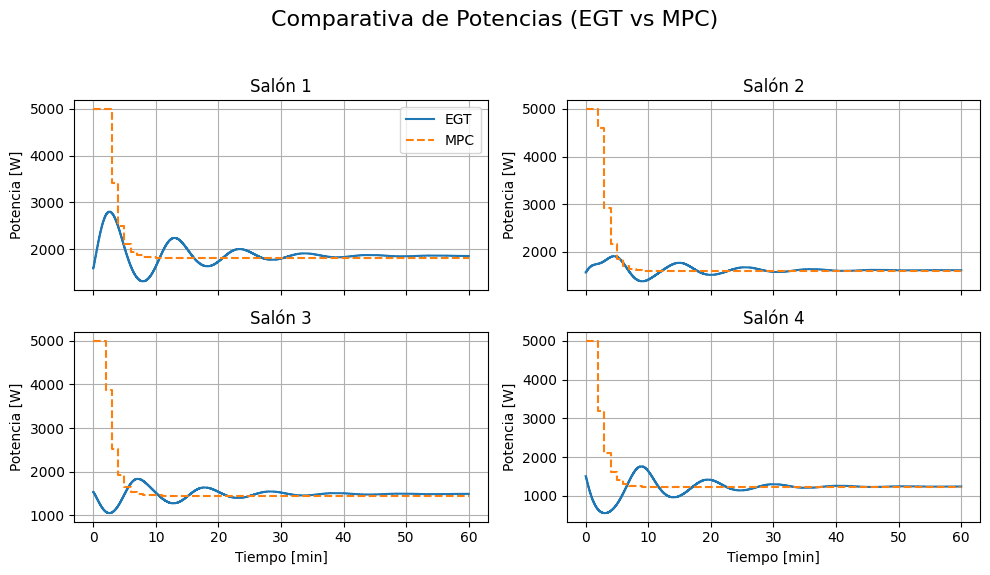

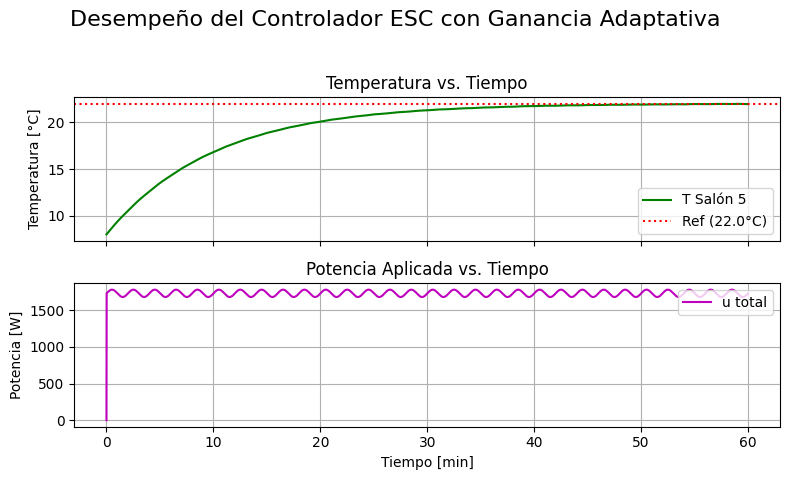

| Métrica | ESC (Adaptativo) | EGT | MPC |
| :--- | :--- | :--- | :--- |
| **Tiempo de Ejecución** | **211 ms** | 493 ms | 35.7 s |
| **Energía Total (1h)** | **6.23 MJ** | 22.32 MJ | 24.73 MJ |
| **Tiempo Est. Promedio (Ts)** | 33.68 min (Salón 5) | 45.2 min (Promedio Salones 1-4) | **5.8 min** (Promedio Salones 1-4) |
| **Error Est. Promedio ($\text{E}_{ss}$) (Media)** | $-0.0559 \text{ °C}$ (Salón 5) | $-0.01 \text{ °C}$ (Promedio Salones 1-4) | $**-0.19 \text{ °C}**$ (Promedio Salones 1-4) |
| **Potencia Est. Promedio ($\text{P}_{ss}$) (Media)** | $1729.51 \text{ W}$ (Salón 5) | $1552.3 \text{ W}$ (Promedio Salones 1-4) | $1521.8 \text{ W}$ (Promedio Salones 1-4) |
| **Amplitud Osc. ($\text{Amp}_{osc}$) (Media)** | $0.0330 \text{ °C}$ (Salón 5) | **$0.0000 \text{ °C}$** (Promedio Salones 1-4) | $0.00 \text{ °C}$ (Promedio Salones 1-4) |


**Desempeño por Salón (EGT y MPC)**

| Salón | Métrica | EGT | MPC |
| :---: | :--- | :---: | :---: |
| **Salón 1** | $t_{est} \text{ [min]}$ | $44.80$ | $6.0$ |
| | $\text{P}_{ss} \text{ [W]}$ | $1855.2$ | $1814.8$ |
| | $\text{E}_{ss} \text{ [°C]}$ | $-0.01$ | $-0.25$ |
| **Salón 2** | $t_{est} \text{ [min]}$ | $45.71$ | $6.0$ |
| | $\text{P}_{ss} \text{ [W]}$ | $1611.8$ | $1592.1$ |
| | $\text{E}_{ss} \text{ [°C]}$ | $-0.01$ | $-0.19$ |
| **Salón 3** | $t_{est} \text{ [min]}$ | $46.25$ | $6.0$ |
| | $\text{P}_{ss} \text{ [W]}$ | $1490.8$ | $1451.4$ |
| | $\text{E}_{ss} \text{ [°C]}$ | $-0.01$ | $-0.19$ |
| **Salón 4** | $t_{est} \text{ [min]}$ | $43.96$ | $5.0$ |
| | $\text{P}_{ss} \text{ [W]}$ | $1242.3$ | $1228.7$ |
| | $\text{E}_{ss} \text{ [°C]}$ | $-0.00$ | $-0.12$ |

A continuación, se presenta un análisis comparativo a través de distintas métricas de desempeño:

#### 1. Comparativa de Desempeño

**Rapidez y Precisión:**
*   **MPC:** Demostró ser, con diferencia, el controlador más rápido y agresivo. La configuración *MPC Cambios* alcanzó las temperaturas de referencia en aproximadamente **6 minutos**, con un error en estado estacionario prácticamente nulo. Esta capacidad de respuesta lo posiciona como la mejor opción para escenarios donde el confort térmico inmediato es la máxima prioridad, como el inicio de una jornada laboral.
*   **EGT:** Exhibió un comportamiento notablemente más suave y progresivo, alcanzando el estado estacionario en cerca de **45 minutos**. A pesar de este tiempo de establecimiento más prolongado, su precisión final es excelente, logrando un error inferior a **0.01 °C** sin oscilaciones. Su respuesta inicial, aunque más lenta, logra reducir el error a menos de 3 °C en los primeros 12 minutos, lo cual puede ser suficiente para muchas aplicaciones de calefacción.
*   **ESC:** Para el sistema de un solo salón, la versión con ganancia adaptativa logró estabilizarse en aproximadamente **34 minutos**. Aunque más lento que el MPC, su capacidad para operar sin un modelo matemático del sistema es una ventaja considerable.

**Eficiencia Energética:**
*   **EGT:** Se destaca como el controlador más eficiente en términos energéticos, con un consumo total en la primera hora de **22.32 MJ**. Su dinámica emergente distribuye la potencia de forma inteligente, asignando recursos solo donde son necesarios y evitando el sobrecalentamiento.
*   **MPC:** La flexibilidad de este controlador permite un claro compromiso entre confort y consumo. La configuración *MPC Cambios* consumió **24.73 MJ**, priorizando la rapidez. En contraste, una configuración más conservadora (*MPC Inicial*) podría reducir drásticamente este consumo a costa de no alcanzar la referencia con total precisión. Esto evidencia que el MPC puede ser tan eficiente como se desee, si se está dispuesto a sacrificar precisión.
*   **ESC:** Su consumo de **6.23 MJ** no es directamente comparable, al tratarse de un único salón. Sin embargo, su lógica de búsqueda del punto óptimo de operación está intrínsecamente orientada a minimizar el esfuerzo de control una vez que se alcanza la referencia.

**Robustez y Cuidado del Actuador:**
*   **EGT:** El comportamiento de la señal de control es el más suave de los tres, sin cambios bruscos ni picos de potencia una vez superado el transitorio inicial. Esto es ideal para preservar la vida útil de los actuadores físicos, minimizando el desgaste.
*   **ESC:** La naturaleza de su funcionamiento introduce una oscilación permanente en la señal de control, aunque de baja amplitud. La implementación de una ganancia adaptativa demostró ser crucial para suavizar la respuesta y estabilizar la búsqueda del óptimo.
*   **MPC:** La configuración agresiva tiende a saturar los actuadores al inicio para acelerar el calentamiento. Su acción de control, al ser una secuencia de pasos constantes, es menos "gentil" que la del EGT.

#### 2. Obstáculos en la Implementación

Cada estrategia presentó desafíos únicos que reflejan su filosofía de diseño:

*   **MPC:** La principal complejidad radica en la necesidad de un modelo matemático preciso del sistema y en la sintonización de las matrices de ponderación (Q y R). Definir estos pesos es un proceso iterativo que requiere un entendimiento claro de los objetivos de control (¿priorizamos energía o confort?). Además, su dependencia de un solver de optimización convexa lo hace computacionalmente el más intensivo.
*   **ESC:** El mayor obstáculo fue su escalabilidad al sistema multizona, lo que nos llevó a simplificar el problema a un solo salón. La sintonización de sus parámetros (amplitud y frecuencia de la perturbación, ganancia de adaptación y constante del filtro) no es trivial y requiere un enfoque empírico.
*   **EGT:** El desafío conceptual fue definir una **función de pago (fitness)** adecuada. Un primer intento con una función simétrica no logró la convergencia esperada, resultando en un comportamiento inestable. La clave del éxito fue la implementación de una función asimétrica simple (el error `T_ref - T_actual`), que corrigió todos los problemas de desempeño y demostró que, en sistemas complejos, la simplicidad puede ser más robusta.

#### 3. Síntesis y Conclusiones

La siguiente tabla resume las características clave de cada controlador:

| Característica | Controlador MPC | Controlador ESC (Adaptativo) | Controlador EGT |
| :--- | :--- | :--- | :--- |
| **Velocidad** | Muy alta (~6 min) | Lenta (~34 min) | Moderada (~45 min) |
| **Precisión (Error SS)** | Nulo (< 0.01 °C) | Bajo (~ -0.05 °C) | Nulo (< 0.01 °C) |
| **Eficiencia Energética** | Configurable (Moderada-Alta) | Alta (no comparable) | Muy alta |
| **Cuidado del Actuador** | Agresivo inicialmente | Oscilatorio | Muy suave |
| **Dependencia del Modelo**| Alta | Nula | Nula (pero requiere el sistema para interactuar) |
| **Complejidad de Sintonía**| Alta (matrices Q y R) | Alta (parámetros de búsqueda) | Moderada (K_rep, U_max, función de pago) |

En conclusión, no existe un "mejor" controlador, sino una solución adecuada para cada contexto.
*   El **MPC** es la herramienta idónea para aplicaciones de alto rendimiento donde la flexibilidad para alternar entre confort máximo y ahorro energético es crucial, y se dispone de un modelo fiable del sistema.
*   El **EGT** representa una solución elegante y altamente eficiente para sistemas donde la preservación de los actuadores y el bajo consumo son prioritarios, aceptando un tiempo de respuesta más largo. Su simplicidad conceptual y robustez lo hacen muy atractivo.
*   El **ESC** sobresale en escenarios donde el modelado del sistema es inviable o demasiado costoso. Su naturaleza adaptativa lo convierte en una opción potente para el control de "cajas negras".

Este proyecto evidencia que, más allá de la optimización centralizada del MPC, los enfoques emergentes y descentralizados como EGT ofrecen soluciones robustas y eficientes que surgen de la interacción de reglas locales simples, abriendo un camino prometedor para el control de sistemas complejos y distribuidos.